# Artificial Neural Networks and Deep Learning - Homework 2


## ⚙️ Import Libraries

In [1]:
!pip install focal-loss # default Keras focal loss does not support class weights 

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

import focal_loss

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 14
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load and prepare the Data

In [3]:
data = np.load("/kaggle/input/homework2/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
# Remove outliers (containing aliens)
outliers = [
    62,
    79,
    125,
    139,
    142,
    147,
    152,
    156,
    170,
    210,
    217,
    266,
    289,
    299,
    313,
    339,
    348,
    365,
    412,
    417,
    426,
    450,
    461,
    536,
    552,
    669,
    675,
    741,
    744,
    747,
    799,
    802,
    808,
    820,
    821,
    849,
    863,
    890,
    909,
    942,
    971,
    1005,
    1057,
    1079,
    1082,
    1092,
    1095,
    1106,
    1119,
    1125,
    1177,
    1194,
    1224,
    1247,
    1248,
    1258,
    1261,
    1262,
    1306,
    1324,
    1365,
    1370,
    1443,
    1449,
    1508,
    1509,
    1519,
    1551,
    1584,
    1588,
    1628,
    1637,
    1693,
    1736,
    1767,
    1768,
    1782,
    1813,
    1816,
    1834,
    1889,
    1925,
    1942,
    1975,
    1979,
    2000,
    2002,
    2086,
    2096,
    2110,
    2111,
    2151,
    2161,
    2222,
    2235,
    2239,
    2242,
    2301,
    2307,
    2350,
    2361,
    2365,
    2372,
    2414,
    2453,
    2522,
    2535,
    2561,
    2609,
    2614,
]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [6]:
# Count the number of pixels with a given label
label_list, counts = np.unique(y_train, return_counts=True)
for label, count in zip(label_list, counts):
    print(f"Number of pixels with label {int(label)}: {count}")

Number of pixels with label 0: 4988826
Number of pixels with label 1: 6957538
Number of pixels with label 2: 4776810
Number of pixels with label 3: 3770823
Number of pixels with label 4: 26963


In [7]:
class_weights = [sum(counts) / counts[i] for i in range(num_classes)]
class_weights[0] = 0
print(class_weights)

[0, 2.9494571211828093, 4.295954831781042, 5.44203745442308, 761.0785150020398]


In [8]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 2087
Number of images containing label 1: 1281
Number of images containing label 2: 1160
Number of images containing label 3: 863
Number of images containing label 4: 63


In [9]:
# Since there are few images with label 4, stratify using the presence of label 4
stratify = []
for labels in y_train:
    label_list = np.unique(labels)
    if 4.0 in label_list:
        stratify.append(1)
    else:
        stratify.append(0)
stratify = np.array(stratify)

In [10]:
# Split into training and validation (90-10)
val_size = 0.1
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=val_size, stratify=stratify
)

In [11]:
# Check imbalance between training and validation
train_counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        train_counts[int(value)] += 1

val_counts = [0 for _ in range(num_classes)]
for labels in y_val:
    label_list = np.unique(labels)
    for value in label_list:
        val_counts[int(value)] += 1

ratios = [val_counts[i] / train_counts[i] / val_size for i in range(num_classes)]

for i in range(num_classes):
    print(
        f"Ratio of images containing a label in validation vs train compared to ideal split for label {i}: {ratios[i]}"
    )

Ratio of images containing a label in validation vs train compared to ideal split for label 0: 1.1128860489882852
Ratio of images containing a label in validation vs train compared to ideal split for label 1: 1.187772925764192
Ratio of images containing a label in validation vs train compared to ideal split for label 2: 1.1861137897782064
Ratio of images containing a label in validation vs train compared to ideal split for label 3: 1.1211340206185567
Ratio of images containing a label in validation vs train compared to ideal split for label 4: 1.0526315789473684


In [12]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label


@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    return image, label

In [14]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [15]:
batch_size = 16

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


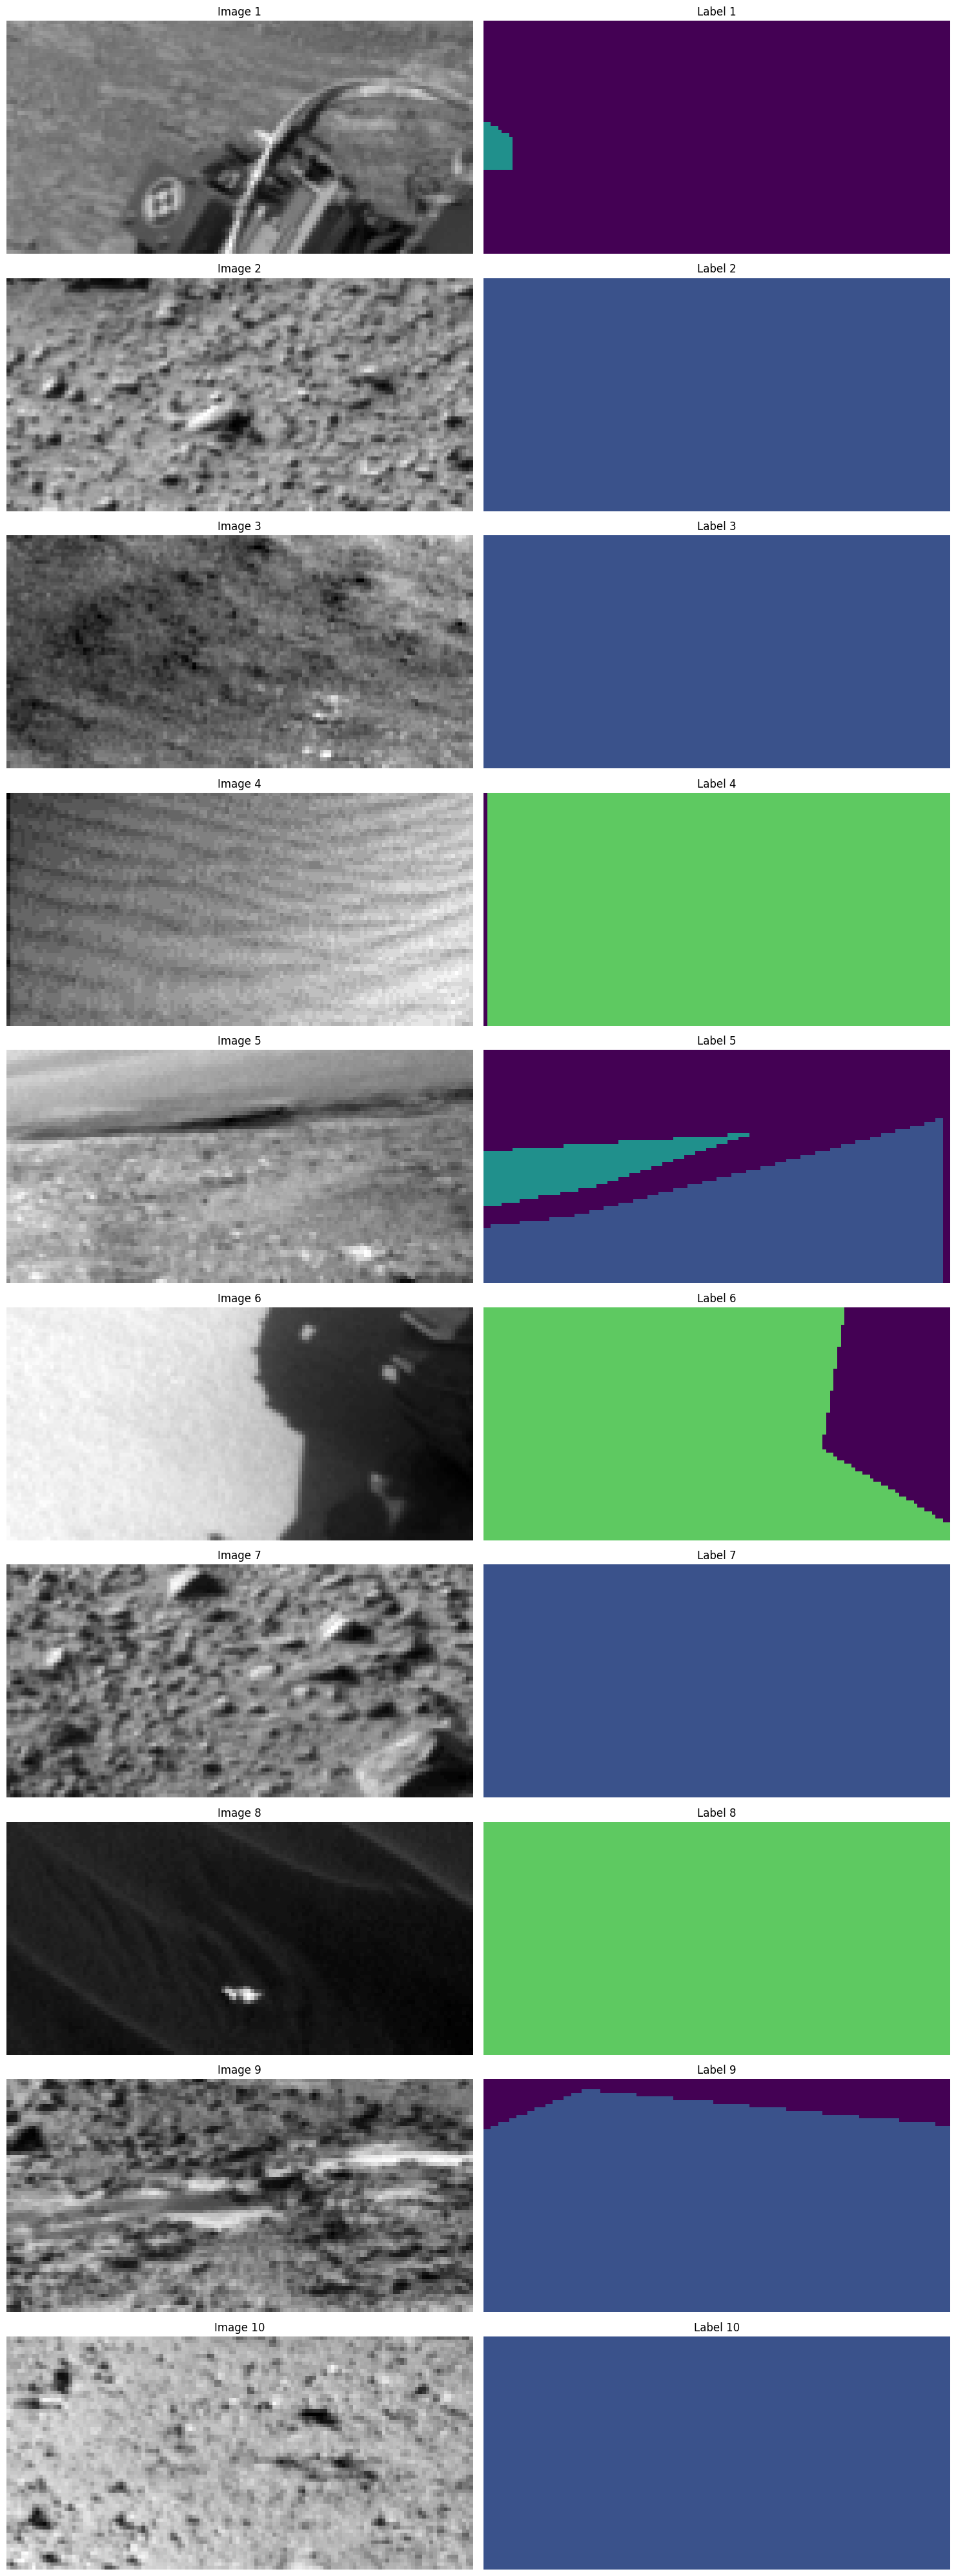

In [16]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="gray")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

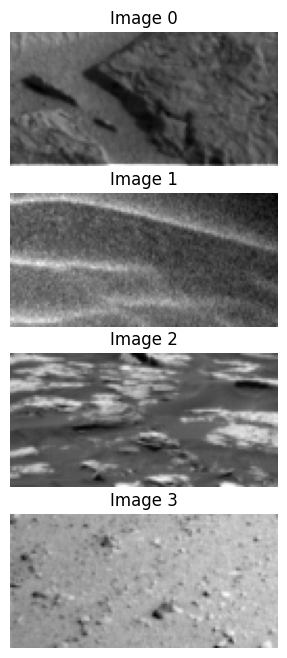

In [17]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="gray")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [18]:
def unet_block(
    input_tensor,
    filters,
    kernel_size=3,
    activation="relu",
    stack=1,
    name="",
    groups=8,
    dilation_rate=1,
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            dilation_rate=dilation_rate,
            kernel_regularizer=tfk.regularizers.L2(
                1e-3
            ),  # L2 regularization to reduce overfitting due to the large number of parameters
            name=name + "conv" + str(i + 1),
        )(x)
        # The layer is a GroupNormalization layer, or InstanceNormalization if groups=1
        # The "bn" in the layer's name is an oversight, as it used to be a BatchNormalization layer
        x = tfkl.GroupNormalization(name=name + "bn" + str(i + 1), groups=groups)(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [23]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")
    base_filters = 64

    # Downsampling path
    down_block_1 = unet_block(input_layer, base_filters, name="down_block1_", groups=1)
    d1 = tfkl.SpatialDropout2D(0.05)(down_block_1)
    d1 = tfkl.MaxPooling2D()(d1)

    down_block_2 = unet_block(d1, base_filters * 2, name="down_block2_", groups=2)
    d2 = tfkl.SpatialDropout2D(0.1)(down_block_2)
    d2 = tfkl.MaxPooling2D()(d2)

    down_block_3 = unet_block(d2, base_filters * 4, name="down_block3_", groups=4)
    d3 = tfkl.SpatialDropout2D(0.15)(down_block_3)
    d3 = tfkl.MaxPooling2D()(d3)

    down_block_4 = unet_block(d3, base_filters * 8, name="down_block4_", groups=8)
    d4 = tfkl.SpatialDropout2D(0.2)(down_block_4)
    d4 = tfkl.MaxPooling2D()(d4)

    down_block_5 = unet_block(d4, base_filters * 16, name="down_block5_", groups=8)
    d5 = tfkl.SpatialDropout2D(0.25)(down_block_5)
    d5 = tfkl.MaxPooling2D()(d5)

    # Bottleneck
    bottleneck = unet_block(
        d5, base_filters * 32, name="bottleneck", groups=8, stack=2, dilation_rate=2
    )  # increasing group size due to increasing number of filters
    bottleneck = tfkl.SpatialDropout2D(0.3)(
        bottleneck
    )  # increasing dropout rates, as deeper levels seem to overfit more

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(
        base_filters * 16, kernel_size=2, strides=2, padding="same"
    )(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_5])
    u1 = unet_block(u1, base_filters * 16, name="up_block1_", groups=8)

    u2 = tfkl.Conv2DTranspose(
        base_filters * 8, kernel_size=2, strides=2, padding="same"
    )(u1)
    u2 = tfkl.Concatenate()([u2, down_block_4])
    u2 = unet_block(u2, base_filters * 8, name="up_block2_", groups=8)

    u3 = tfkl.Conv2DTranspose(
        base_filters * 4, kernel_size=2, strides=2, padding="same"
    )(u2)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, base_filters * 4, name="up_block3_", groups=4)

    u4 = tfkl.Conv2DTranspose(
        base_filters * 2, kernel_size=2, strides=2, padding="same"
    )(u3)
    u4 = tfkl.Concatenate()([u4, down_block_2])
    u4 = unet_block(u4, base_filters * 2, name="up_block4_", groups=2)

    u5 = tfkl.Conv2DTranspose(base_filters, kernel_size=2, strides=2, padding="same")(
        u4
    )
    u5 = tfkl.Concatenate()([u5, down_block_1])
    u5 = unet_block(u5, base_filters, name="up_block5_", groups=1)

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="UNet")
    return model

In [24]:
# Define some hyperparameters
epochs = 1000
patience = 45
learning_rate = 1e-4

In [25]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture
try:
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)
except:
    print("Model too complex to plot!")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout2d │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│ (SpatialDropout2… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ spatial_dropo… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (GroupNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout2… │ (None, 32, 64,  │         0 │ down_block2_a… │   -   │
│ (SpatialDropout2… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ spatial_dropo… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │       512 │ down_block3_c… │   Y   │
│ (GroupNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_acti… │ (None, 16, 32,  │         0 │ down_block3_b… │   -   │
│ (Activation)      │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout2… │ (None, 16, 32,  │         0 │ down_block3_a… │   -   │
│ (SpatialDropout2… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_2   │ (None, 8, 16,   │         0 │ spatial_dropo… │   -   │
│ (MaxPooling2D)    │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block4_conv1 │ (None, 8, 16,   │ 1,180,160 │ max_pooling2d… │   Y 

 Total params: 99,232,197 (378.54 MB)

 Trainable params: 99,232,197 (378.54 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [26]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [27]:
from tensorflow.keras import backend as K


def iou_loss(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    :param y_true: Ground truth tensor (not one-hot encoded).
    :param y_pred: Predicted tensor (probabilities or logits).
    :param smooth: Smoothing factor to avoid division by zero.
    :return: IoU loss value.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    # Loop over all classes (excluding class 0)
    for i in range(1, num_classes):  # Start from 1 to exclude background (class 0)
        # Get the probabilities for the current class (class i)
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        # Flatten the predicted probabilities and true labels for class i
        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        # Calculate intersection and union for class i
        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = K.mean(K.stack(iou_values))

    # Return mean IoU loss (1 - mean IoU)
    return 1 - mean_iou

In [28]:
def dice_loss(y_true, y_pred, num_classes=num_classes, ignore_class=0, smooth=1e-6):
    """
    Computes the Dice loss with the option to ignore a specific class.

    Parameters:
        y_true (tensor): Ground truth segmentation mask (one-hot encoded).
        y_pred (tensor): Predicted segmentation mask (one-hot encoded).
        ignore_class (int): The class label to be ignored in the calculation (default is 0).

    Returns:
        float: The Dice loss, excluding the `ignore_class`.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Flatten the tensors to compute dice coefficient for each class
    y_true_f = K.flatten(y_true_one_hot)
    y_pred_f = K.flatten(y_pred)

    # Calculate the Dice coefficient for each class
    dice_per_class = []

    for i in range(num_classes):
        if i == ignore_class:
            continue
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
        dice_per_class.append(dice_coeff)

    # Return the mean Dice coefficient
    return 1 - K.mean(K.stack(dice_per_class))

In [29]:
# Define a custom loss
class CustomLoss(tfk.losses.Loss):
    def __init__(self, alpha, num_classes=num_classes, name="custom_loss", **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)
        self.alpha = alpha
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        # Calculate the loss
        return (1 - self.alpha) * focal_loss.sparse_categorical_focal_loss(
            y_true, y_pred, class_weight=class_weights, gamma=3.0
        ) + self.alpha * iou_loss(y_true, y_pred)

In [30]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=CustomLoss(0.8),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0]),
    ],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [31]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

image, label = val_dataset.take(1).get_single_element()
viz_callback = VizCallback(image[1:2, ...], label[1:2, ...])

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 3, factor=0.1, min_lr=learning_rate * 1e-4
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

Epoch 1/1000


I0000 00:00:1734173663.049247      70 service.cc:145] XLA service 0x7e709c003590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734173663.049322      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/141 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.2232 - loss: 8.5984 - mean_iou: 0.0886   

I0000 00:00:1734173686.610643      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2280 - loss: 5.9085 - mean_iou: 0.1082

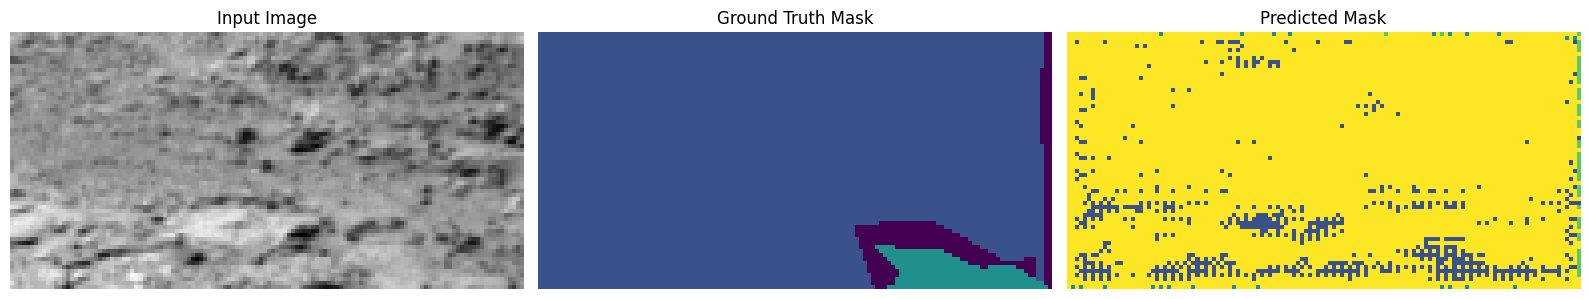

141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 330ms/step - accuracy: 0.2279 - loss: 5.8966 - mean_iou: 0.1082 - val_accuracy: 0.0454 - val_loss: 2.1593 - val_mean_iou: 0.0294 - learning_rate: 1.0000e-04
Epoch 2/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.1915 - loss: 1.9703 - mean_iou: 0.1290 - val_accuracy: 0.1716 - val_loss: 1.6067 - val_mean_iou: 0.0955 - learning_rate: 1.0000e-04
Epoch 3/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.2628 - loss: 1.5682 - mean_iou: 0.1761 - val_accuracy: 0.2705 - val_loss: 1.4114 - val_mean_iou: 0.2188 - learning_rate: 1.0000e-04
Epoch 4/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.3233 - loss: 1.3943 - mean_iou: 0.2238 - val_accuracy: 0.3105 - val_loss: 1.3030 - val_mean_iou: 0.2534 - learning_rate: 1.0000e-04
Epoch 5/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.3612 - loss: 1.3010 - mean_iou: 0.2589 - val_accuracy: 0.3418 - val_loss: 1.2439 - val_mean_iou: 0.2679 - learning_rate: 1.0000e-04
Ep

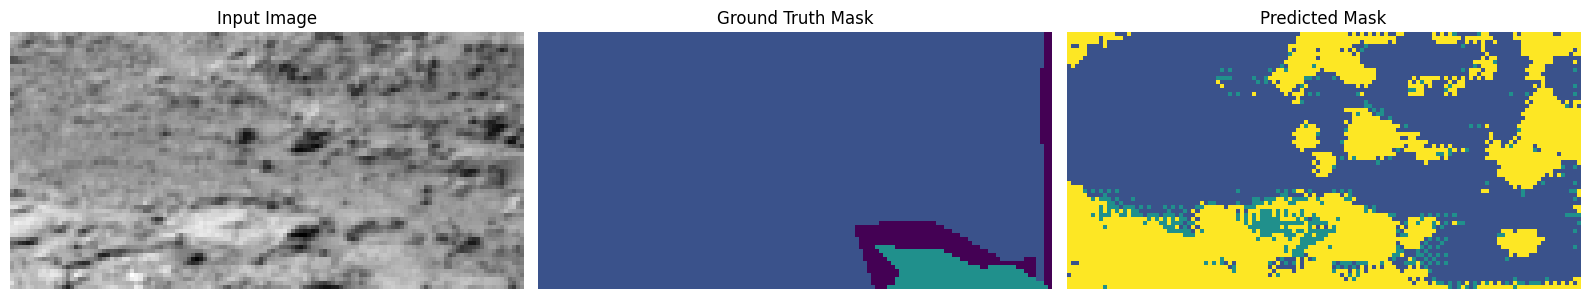

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.3756 - loss: 1.2499 - mean_iou: 0.2727 - val_accuracy: 0.3524 - val_loss: 1.1908 - val_mean_iou: 0.2770 - learning_rate: 1.0000e-04
Epoch 7/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.3931 - loss: 1.2018 - mean_iou: 0.2905 - val_accuracy: 0.3525 - val_loss: 1.2140 - val_mean_iou: 0.2665 - learning_rate: 1.0000e-04
Epoch 8/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.4134 - loss: 1.1626 - mean_iou: 0.3118 - val_accuracy: 0.3752 - val_loss: 1.1346 - val_mean_iou: 0.2949 - learning_rate: 1.0000e-04
Epoch 9/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.4332 - loss: 1.1307 - mean_iou: 0.3289 - val_accuracy: 0.3998 - val_loss: 1.0965 - val_mean_iou: 0.3363 - learning_rate: 1.0000e-04
Epoch 10/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4447 - loss: 1.1022 - mean_iou: 0.3394 - val_accuracy: 0.3640 - val_loss: 1.1290 - val_mean_iou: 0.2842 - learning_rate: 1.0000e-04
Ep

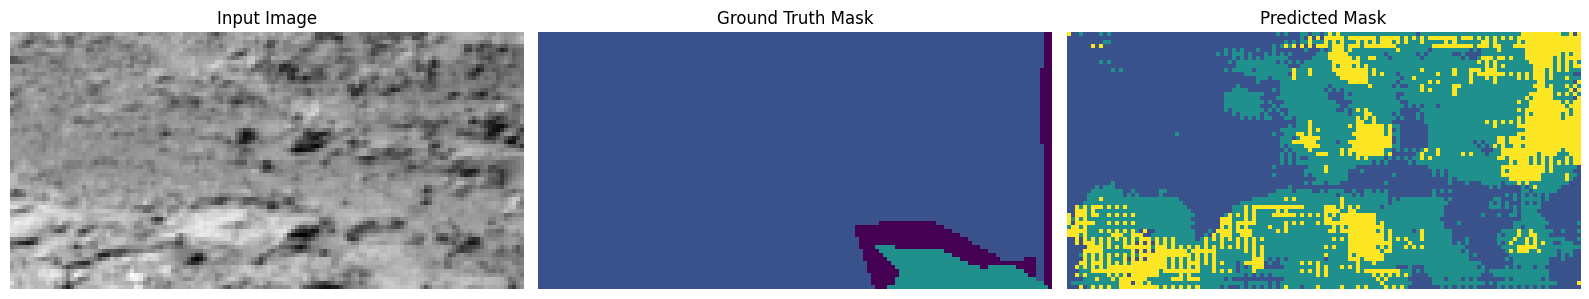

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.4436 - loss: 1.1077 - mean_iou: 0.3358 - val_accuracy: 0.4041 - val_loss: 1.0809 - val_mean_iou: 0.3391 - learning_rate: 1.0000e-04
Epoch 12/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4785 - loss: 1.0489 - mean_iou: 0.3760 - val_accuracy: 0.3555 - val_loss: 1.1195 - val_mean_iou: 0.2888 - learning_rate: 1.0000e-04
Epoch 13/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.4639 - loss: 1.0596 - mean_iou: 0.3623 - val_accuracy: 0.4701 - val_loss: 1.0083 - val_mean_iou: 0.3923 - learning_rate: 1.0000e-04
Epoch 14/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5025 - loss: 1.0144 - mean_iou: 0.3991 - val_accuracy: 0.4447 - val_loss: 1.0021 - val_mean_iou: 0.3857 - learning_rate: 1.0000e-04
Epoch 15/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5044 - loss: 0.9994 - mean_iou: 0.4048 - val_accuracy: 0.4478 - val_loss: 0.9899 - val_mean_iou: 0.3841 - learning_rate: 1.0000e-04

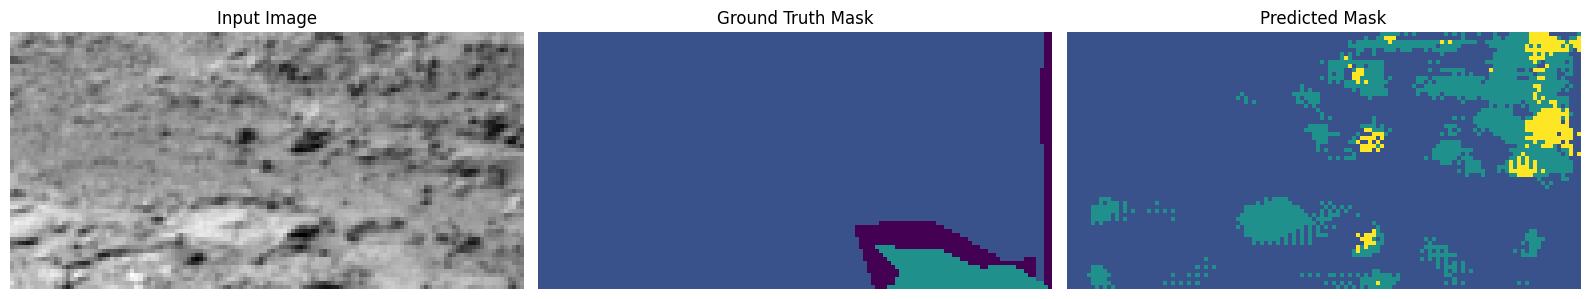

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5049 - loss: 0.9787 - mean_iou: 0.4045 - val_accuracy: 0.4620 - val_loss: 0.9834 - val_mean_iou: 0.3900 - learning_rate: 1.0000e-04
Epoch 17/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4862 - loss: 1.0196 - mean_iou: 0.3802 - val_accuracy: 0.4060 - val_loss: 1.0296 - val_mean_iou: 0.3451 - learning_rate: 1.0000e-04
Epoch 18/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5017 - loss: 0.9719 - mean_iou: 0.4040 - val_accuracy: 0.4692 - val_loss: 0.9629 - val_mean_iou: 0.3983 - learning_rate: 1.0000e-04
Epoch 19/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5121 - loss: 0.9580 - mean_iou: 0.4139 - val_accuracy: 0.4627 - val_loss: 0.9565 - val_mean_iou: 0.3999 - learning_rate: 1.0000e-04
Epoch 20/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5040 - loss: 0.9641 - mean_iou: 0.4081 - val_accuracy: 0.4441 - val_loss: 0.9802 - val_mean_iou: 0.3762 - learning_rate: 1.0000e-04

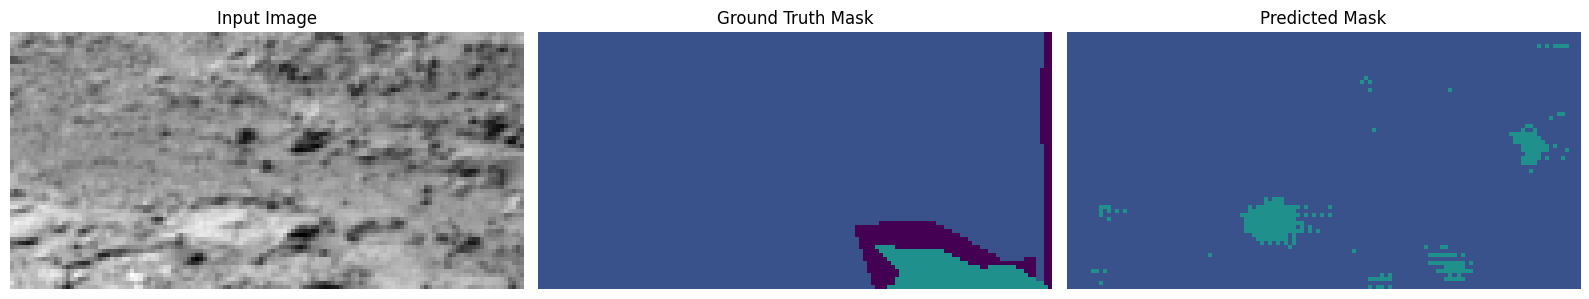

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.5142 - loss: 0.9451 - mean_iou: 0.4177 - val_accuracy: 0.4986 - val_loss: 0.9388 - val_mean_iou: 0.4026 - learning_rate: 1.0000e-04
Epoch 22/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5124 - loss: 0.9439 - mean_iou: 0.4050 - val_accuracy: 0.4695 - val_loss: 0.9418 - val_mean_iou: 0.3981 - learning_rate: 1.0000e-04
Epoch 23/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5256 - loss: 0.9225 - mean_iou: 0.4300 - val_accuracy: 0.4255 - val_loss: 1.0193 - val_mean_iou: 0.3454 - learning_rate: 1.0000e-04
Epoch 24/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5178 - loss: 0.9350 - mean_iou: 0.4189 - val_accuracy: 0.4445 - val_loss: 0.9708 - val_mean_iou: 0.3715 - learning_rate: 1.0000e-04
Epoch 25/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5237 - loss: 0.9217 - mean_iou: 0.4250 - val_accuracy: 0.3898 - val_loss: 1.0199 - val_mean_iou: 0.3237 - learning_rate: 1.0000e-04

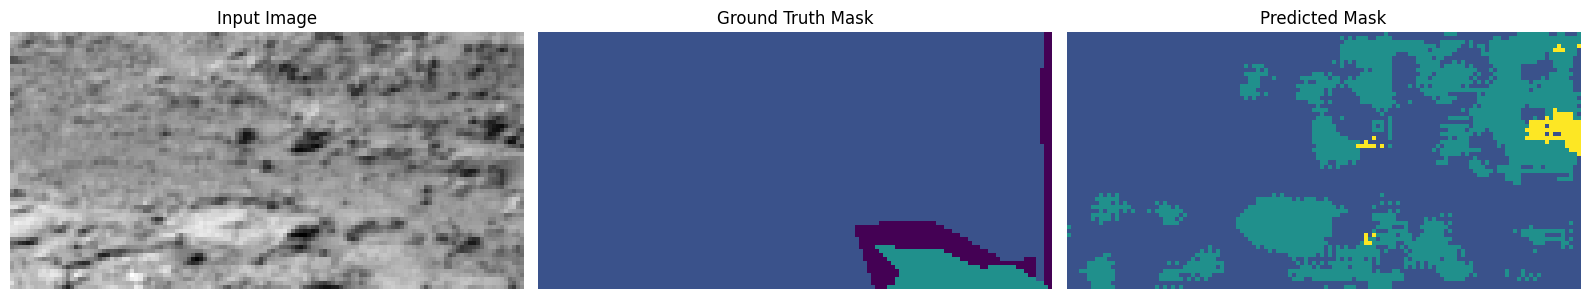

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.5071 - loss: 0.9344 - mean_iou: 0.4101 - val_accuracy: 0.4908 - val_loss: 0.9018 - val_mean_iou: 0.4228 - learning_rate: 1.0000e-04
Epoch 27/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5274 - loss: 0.9010 - mean_iou: 0.4341 - val_accuracy: 0.5176 - val_loss: 0.8781 - val_mean_iou: 0.4390 - learning_rate: 1.0000e-04
Epoch 28/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5368 - loss: 0.8928 - mean_iou: 0.4404 - val_accuracy: 0.4694 - val_loss: 0.9274 - val_mean_iou: 0.4053 - learning_rate: 1.0000e-04
Epoch 29/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5222 - loss: 0.9065 - mean_iou: 0.4289 - val_accuracy: 0.4753 - val_loss: 0.9259 - val_mean_iou: 0.4023 - learning_rate: 1.0000e-04
Epoch 30/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5255 - loss: 0.9063 - mean_iou: 0.4286 - val_accuracy: 0.4921 - val_loss: 0.8958 - val_mean_iou: 0.4200 - learning_rate: 1.0000e-04

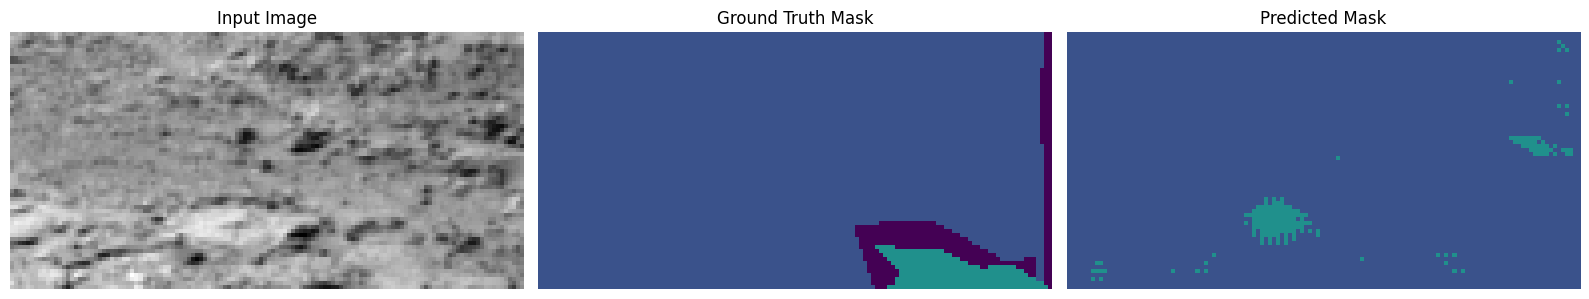

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5240 - loss: 0.8979 - mean_iou: 0.4318 - val_accuracy: 0.5187 - val_loss: 0.8633 - val_mean_iou: 0.4374 - learning_rate: 1.0000e-04
Epoch 32/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5446 - loss: 0.8660 - mean_iou: 0.4522 - val_accuracy: 0.4975 - val_loss: 0.8762 - val_mean_iou: 0.4258 - learning_rate: 1.0000e-04
Epoch 33/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5449 - loss: 0.8666 - mean_iou: 0.4538 - val_accuracy: 0.4531 - val_loss: 0.9321 - val_mean_iou: 0.3902 - learning_rate: 1.0000e-04
Epoch 34/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5245 - loss: 0.8842 - mean_iou: 0.4352 - val_accuracy: 0.4870 - val_loss: 0.8849 - val_mean_iou: 0.4224 - learning_rate: 1.0000e-04
Epoch 35/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5294 - loss: 0.8757 - mean_iou: 0.4380 - val_accuracy: 0.5071 - val_loss: 0.8882 - val_mean_iou: 0.4353 - learning_rate: 1.0000e-04

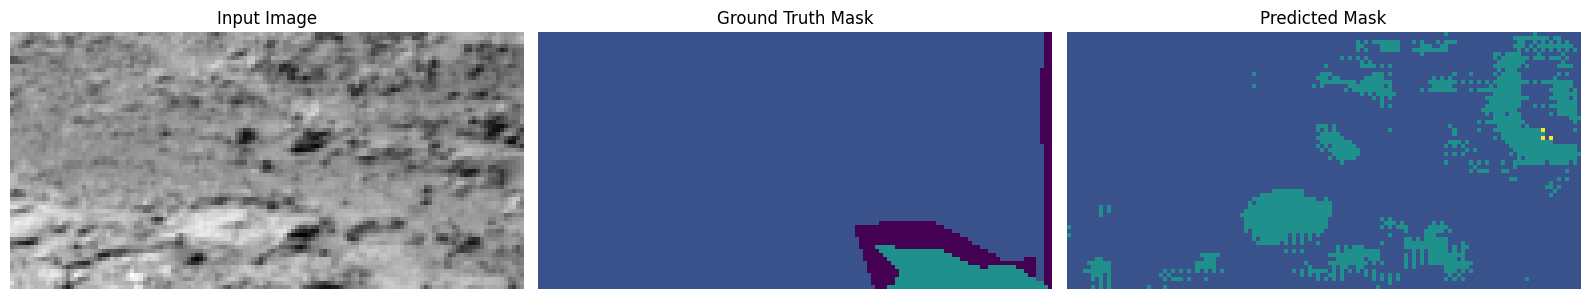

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.5352 - loss: 0.8748 - mean_iou: 0.4417 - val_accuracy: 0.5287 - val_loss: 0.8345 - val_mean_iou: 0.4511 - learning_rate: 1.0000e-04
Epoch 37/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5543 - loss: 0.8442 - mean_iou: 0.4642 - val_accuracy: 0.5156 - val_loss: 0.8572 - val_mean_iou: 0.4430 - learning_rate: 1.0000e-04
Epoch 38/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5535 - loss: 0.8463 - mean_iou: 0.4675 - val_accuracy: 0.4910 - val_loss: 0.8863 - val_mean_iou: 0.4217 - learning_rate: 1.0000e-04
Epoch 39/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5393 - loss: 0.8600 - mean_iou: 0.4501 - val_accuracy: 0.4841 - val_loss: 0.8883 - val_mean_iou: 0.4194 - learning_rate: 1.0000e-04
Epoch 40/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5327 - loss: 0.8667 - mean_iou: 0.4432 - val_accuracy: 0.5411 - val_loss: 0.8222 - val_mean_iou: 0.4605 - learning_rate: 1.0000e-04

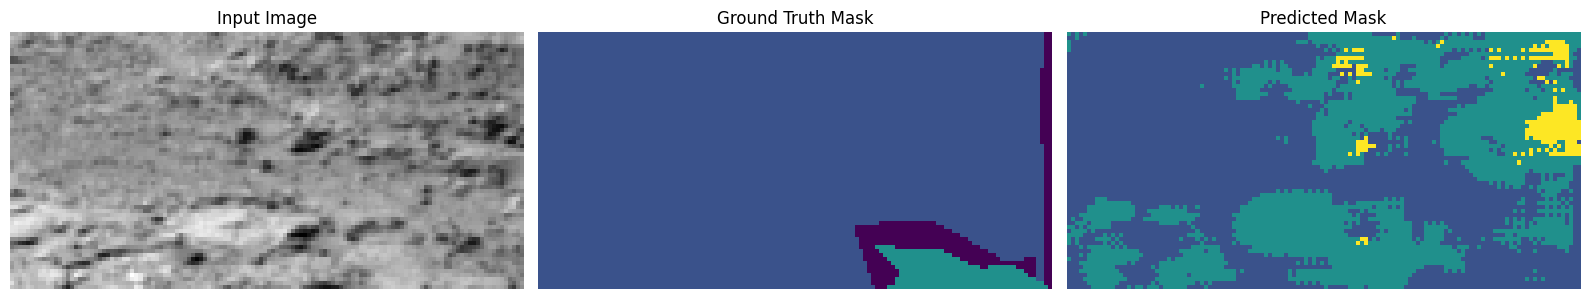

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5562 - loss: 0.8368 - mean_iou: 0.4669 - val_accuracy: 0.4888 - val_loss: 0.8724 - val_mean_iou: 0.4214 - learning_rate: 1.0000e-04
Epoch 42/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5451 - loss: 0.8485 - mean_iou: 0.4575 - val_accuracy: 0.5236 - val_loss: 0.8358 - val_mean_iou: 0.4486 - learning_rate: 1.0000e-04
Epoch 43/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5540 - loss: 0.8387 - mean_iou: 0.4643 - val_accuracy: 0.5374 - val_loss: 0.8247 - val_mean_iou: 0.4613 - learning_rate: 1.0000e-04
Epoch 44/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5522 - loss: 0.8334 - mean_iou: 0.4628 - val_accuracy: 0.5348 - val_loss: 0.8164 - val_mean_iou: 0.4593 - learning_rate: 1.0000e-04
Epoch 45/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5681 - loss: 0.8174 - mean_iou: 0.4841 - val_accuracy: 0.5485 - val_loss: 0.8280 - val_mean_iou: 0.4637 - learning_rate: 1.0000e-04

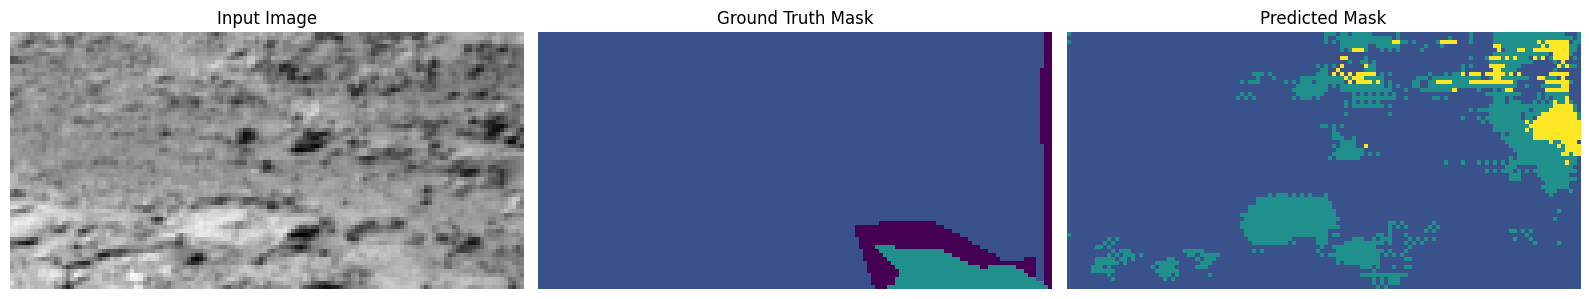

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5646 - loss: 0.8264 - mean_iou: 0.4755 - val_accuracy: 0.5278 - val_loss: 0.8248 - val_mean_iou: 0.4540 - learning_rate: 1.0000e-04
Epoch 47/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5597 - loss: 0.8312 - mean_iou: 0.4740 - val_accuracy: 0.5287 - val_loss: 0.8476 - val_mean_iou: 0.4521 - learning_rate: 1.0000e-04
Epoch 48/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5658 - loss: 0.8382 - mean_iou: 0.4752 - val_accuracy: 0.4926 - val_loss: 0.8693 - val_mean_iou: 0.4272 - learning_rate: 1.0000e-04
Epoch 49/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5492 - loss: 0.8399 - mean_iou: 0.4613 - val_accuracy: 0.5261 - val_loss: 0.8255 - val_mean_iou: 0.4525 - learning_rate: 1.0000e-04
Epoch 50/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5639 - loss: 0.8170 - mean_iou: 0.4776 - val_accuracy: 0.5446 - val_loss: 0.8059 - val_mean_iou: 0.4647 - learning_rate: 1.0000e-04

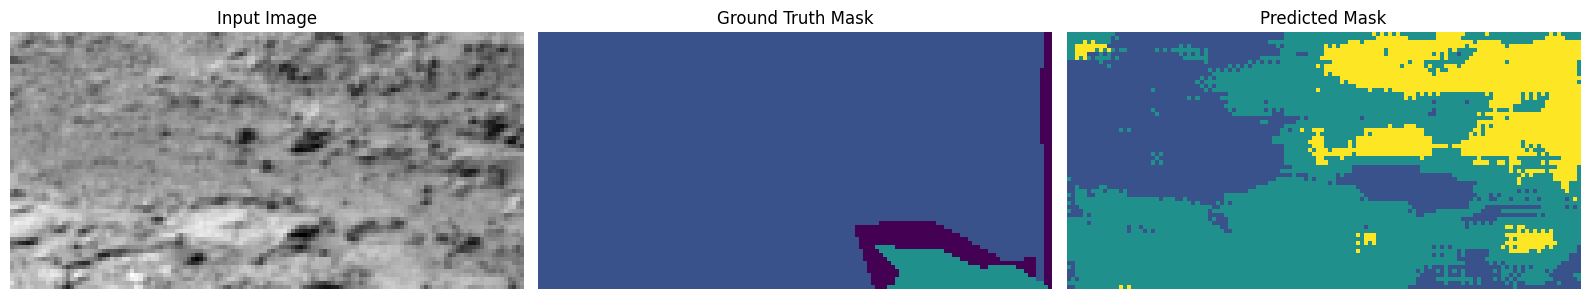

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5798 - loss: 0.8005 - mean_iou: 0.4960 - val_accuracy: 0.4954 - val_loss: 0.8556 - val_mean_iou: 0.4292 - learning_rate: 1.0000e-04
Epoch 52/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5471 - loss: 0.8377 - mean_iou: 0.4618 - val_accuracy: 0.5552 - val_loss: 0.7982 - val_mean_iou: 0.4764 - learning_rate: 1.0000e-04
Epoch 53/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5707 - loss: 0.8044 - mean_iou: 0.4845 - val_accuracy: 0.5526 - val_loss: 0.7927 - val_mean_iou: 0.4735 - learning_rate: 1.0000e-04
Epoch 54/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5778 - loss: 0.7993 - mean_iou: 0.4924 - val_accuracy: 0.5357 - val_loss: 0.8147 - val_mean_iou: 0.4601 - learning_rate: 1.0000e-04
Epoch 55/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5835 - loss: 0.7901 - mean_iou: 0.5012 - val_accuracy: 0.5317 - val_loss: 0.8015 - val_mean_iou: 0.4616 - learning_rate: 1.0000e-04

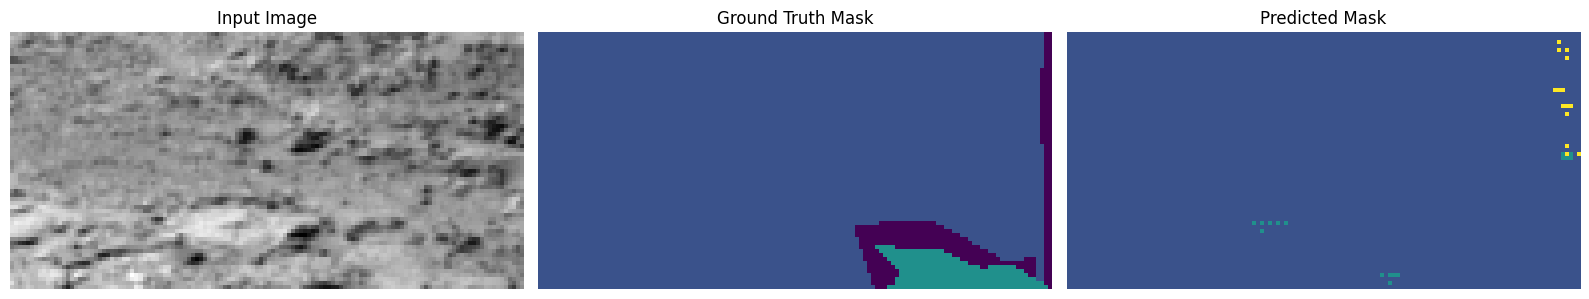

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5782 - loss: 0.7997 - mean_iou: 0.4947 - val_accuracy: 0.5522 - val_loss: 0.8127 - val_mean_iou: 0.4671 - learning_rate: 1.0000e-04
Epoch 57/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5828 - loss: 0.7901 - mean_iou: 0.4975 - val_accuracy: 0.5180 - val_loss: 0.8333 - val_mean_iou: 0.4464 - learning_rate: 1.0000e-04
Epoch 58/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5749 - loss: 0.7937 - mean_iou: 0.4903 - val_accuracy: 0.5428 - val_loss: 0.7963 - val_mean_iou: 0.4718 - learning_rate: 1.0000e-04
Epoch 59/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5856 - loss: 0.7843 - mean_iou: 0.5031 - val_accuracy: 0.5529 - val_loss: 0.8144 - val_mean_iou: 0.4752 - learning_rate: 1.0000e-04
Epoch 60/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5711 - loss: 0.7968 - mean_iou: 0.4849 - val_accuracy: 0.5048 - val_loss: 0.8491 - val_mean_iou: 0.4425 - learning_rate: 1.0000e-04

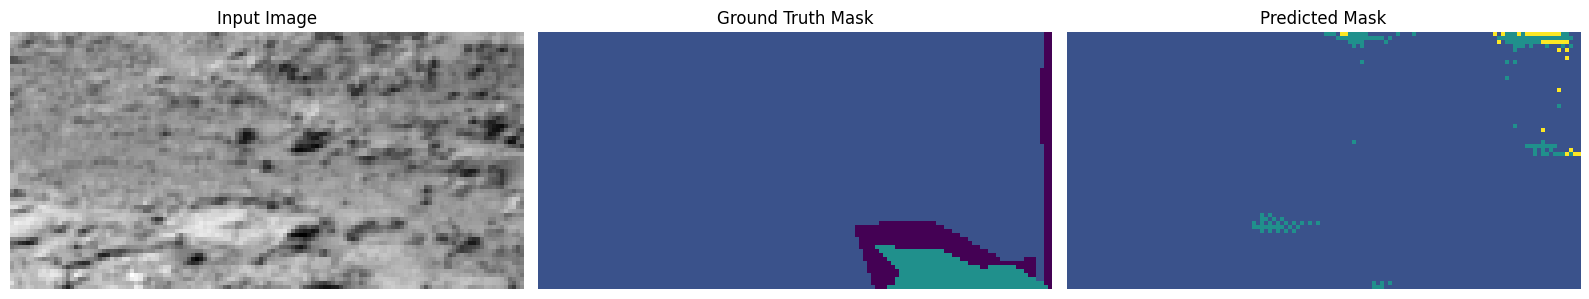

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5734 - loss: 0.8035 - mean_iou: 0.4905 - val_accuracy: 0.5690 - val_loss: 0.7976 - val_mean_iou: 0.4854 - learning_rate: 1.0000e-04
Epoch 62/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5897 - loss: 0.7744 - mean_iou: 0.5049 - val_accuracy: 0.5397 - val_loss: 0.8041 - val_mean_iou: 0.4659 - learning_rate: 1.0000e-04
Epoch 63/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5904 - loss: 0.7734 - mean_iou: 0.5096 - val_accuracy: 0.4892 - val_loss: 0.8652 - val_mean_iou: 0.4287 - learning_rate: 1.0000e-04
Epoch 64/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5609 - loss: 0.8193 - mean_iou: 0.4812 - val_accuracy: 0.5543 - val_loss: 0.7820 - val_mean_iou: 0.4800 - learning_rate: 1.0000e-04
Epoch 65/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5857 - loss: 0.7688 - mean_iou: 0.5025 - val_accuracy: 0.5337 - val_loss: 0.8220 - val_mean_iou: 0.4583 - learning_rate: 1.0000e-04

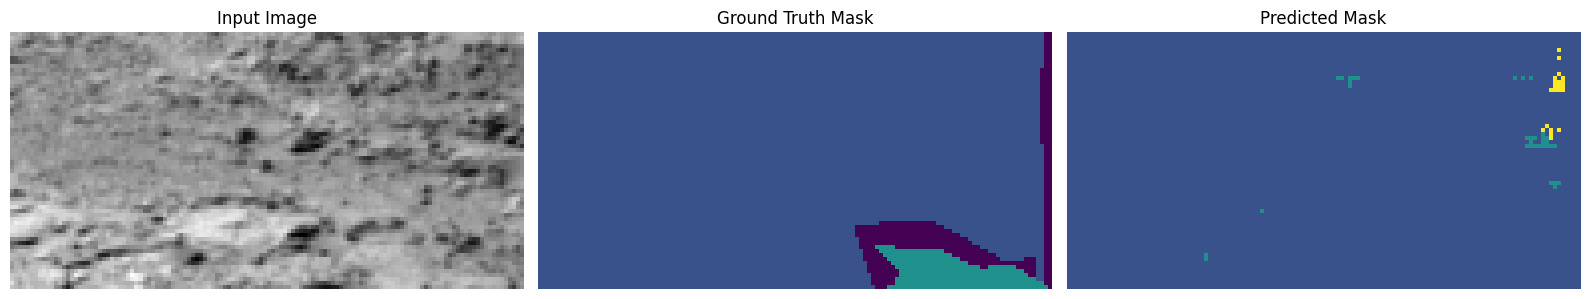

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5859 - loss: 0.7811 - mean_iou: 0.5014 - val_accuracy: 0.5714 - val_loss: 0.7639 - val_mean_iou: 0.4950 - learning_rate: 1.0000e-04
Epoch 67/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5991 - loss: 0.7564 - mean_iou: 0.5187 - val_accuracy: 0.5388 - val_loss: 0.8054 - val_mean_iou: 0.4653 - learning_rate: 1.0000e-04
Epoch 68/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5940 - loss: 0.7702 - mean_iou: 0.5139 - val_accuracy: 0.5824 - val_loss: 0.7518 - val_mean_iou: 0.5129 - learning_rate: 1.0000e-04
Epoch 69/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6036 - loss: 0.7619 - mean_iou: 0.5244 - val_accuracy: 0.5615 - val_loss: 0.7840 - val_mean_iou: 0.4857 - learning_rate: 1.0000e-04
Epoch 70/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6054 - loss: 0.7483 - mean_iou: 0.5270 - val_accuracy: 0.4995 - val_loss: 0.8591 - val_mean_iou: 0.4351 - learning_rate: 1.0000e-04

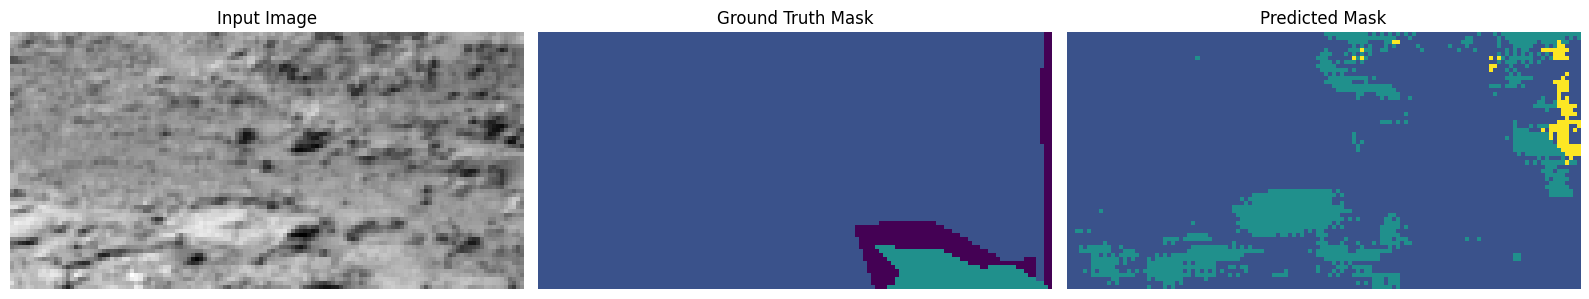

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5892 - loss: 0.7750 - mean_iou: 0.5109 - val_accuracy: 0.5770 - val_loss: 0.7708 - val_mean_iou: 0.5030 - learning_rate: 1.0000e-04
Epoch 72/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6060 - loss: 0.7512 - mean_iou: 0.5274 - val_accuracy: 0.5292 - val_loss: 0.8099 - val_mean_iou: 0.4545 - learning_rate: 1.0000e-04
Epoch 73/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5984 - loss: 0.7568 - mean_iou: 0.5203 - val_accuracy: 0.5516 - val_loss: 0.7746 - val_mean_iou: 0.4840 - learning_rate: 1.0000e-04
Epoch 74/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6012 - loss: 0.7493 - mean_iou: 0.5229 - val_accuracy: 0.5851 - val_loss: 0.7600 - val_mean_iou: 0.5091 - learning_rate: 1.0000e-04
Epoch 75/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5984 - loss: 0.7672 - mean_iou: 0.5157 - val_accuracy: 0.5573 - val_loss: 0.7767 - val_mean_iou: 0.4788 - learning_rate: 1.0000e-04

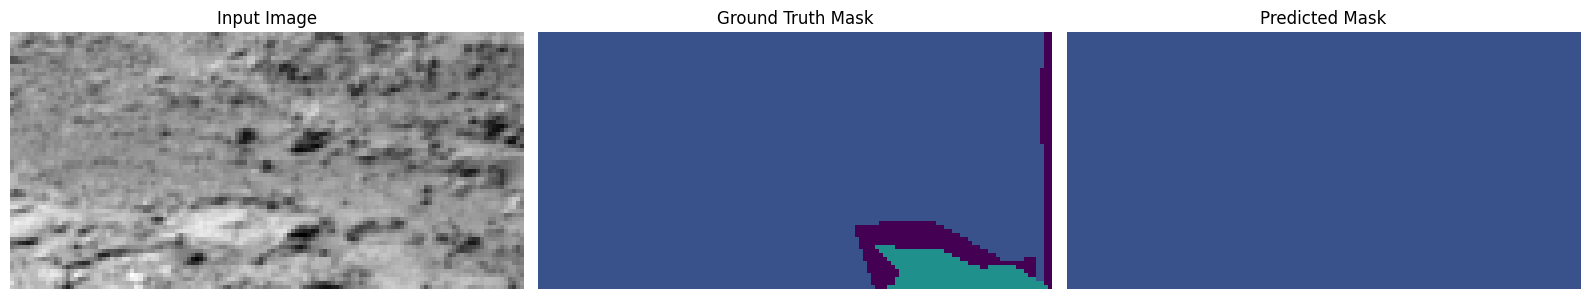

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6133 - loss: 0.7305 - mean_iou: 0.5377 - val_accuracy: 0.6070 - val_loss: 0.7376 - val_mean_iou: 0.5356 - learning_rate: 1.0000e-04
Epoch 77/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6185 - loss: 0.7261 - mean_iou: 0.5453 - val_accuracy: 0.5831 - val_loss: 0.7667 - val_mean_iou: 0.5096 - learning_rate: 1.0000e-04
Epoch 78/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6202 - loss: 0.7240 - mean_iou: 0.5470 - val_accuracy: 0.4114 - val_loss: 0.9801 - val_mean_iou: 0.3577 - learning_rate: 1.0000e-04
Epoch 79/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5388 - loss: 0.8677 - mean_iou: 0.4565 - val_accuracy: 0.5686 - val_loss: 0.7616 - val_mean_iou: 0.4984 - learning_rate: 1.0000e-04
Epoch 80/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6075 - loss: 0.7367 - mean_iou: 0.5303 - val_accuracy: 0.5821 - val_loss: 0.7470 - val_mean_iou: 0.5091 - learning_rate: 1.0000e-04

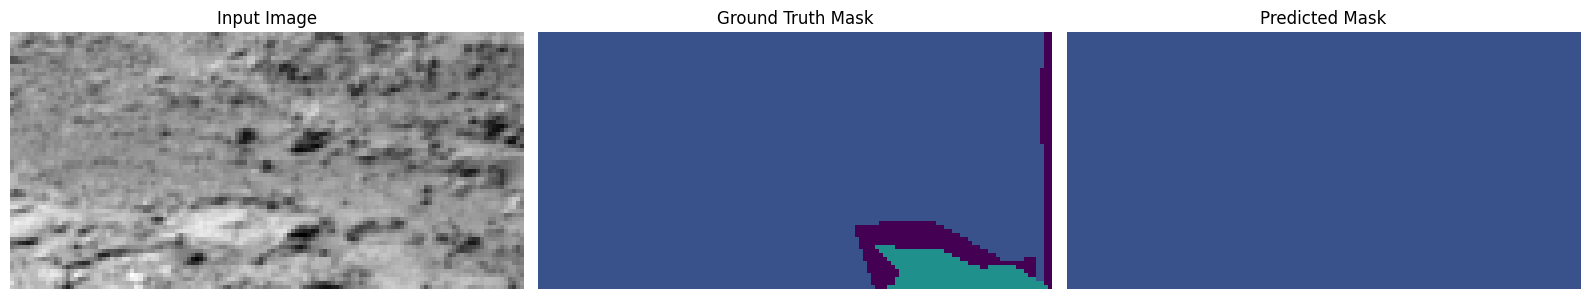

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6197 - loss: 0.7170 - mean_iou: 0.5476 - val_accuracy: 0.5881 - val_loss: 0.7435 - val_mean_iou: 0.5163 - learning_rate: 1.0000e-04
Epoch 82/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6259 - loss: 0.7161 - mean_iou: 0.5560 - val_accuracy: 0.5820 - val_loss: 0.7619 - val_mean_iou: 0.5058 - learning_rate: 1.0000e-04
Epoch 83/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6170 - loss: 0.7322 - mean_iou: 0.5413 - val_accuracy: 0.5902 - val_loss: 0.7301 - val_mean_iou: 0.5166 - learning_rate: 1.0000e-04
Epoch 84/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6218 - loss: 0.7174 - mean_iou: 0.5493 - val_accuracy: 0.5693 - val_loss: 0.7721 - val_mean_iou: 0.4966 - learning_rate: 1.0000e-04
Epoch 85/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6136 - loss: 0.7243 - mean_iou: 0.5422 - val_accuracy: 0.5904 - val_loss: 0.7362 - val_mean_iou: 0.5119 - learning_rate: 1.0000e-04

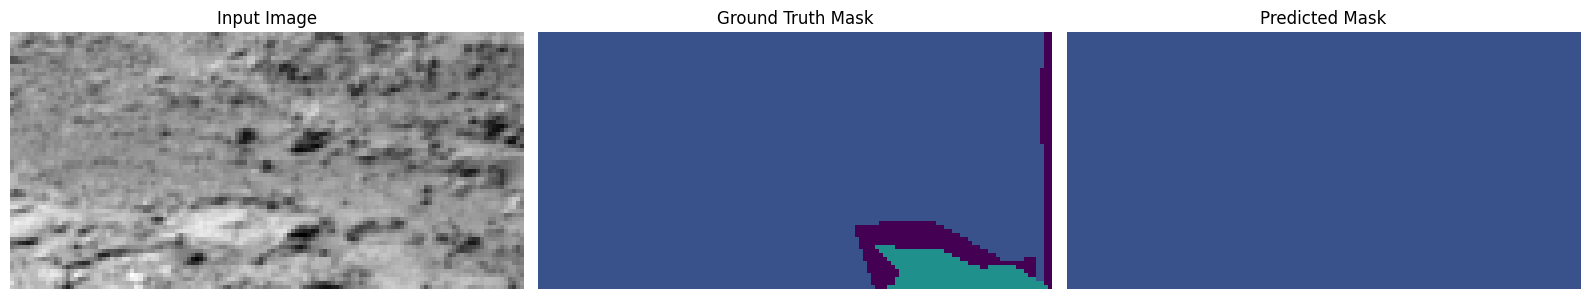

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6288 - loss: 0.7041 - mean_iou: 0.5581 - val_accuracy: 0.6053 - val_loss: 0.7139 - val_mean_iou: 0.5334 - learning_rate: 1.0000e-04
Epoch 87/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6275 - loss: 0.7052 - mean_iou: 0.5564 - val_accuracy: 0.6055 - val_loss: 0.7456 - val_mean_iou: 0.5286 - learning_rate: 1.0000e-04
Epoch 88/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6359 - loss: 0.6893 - mean_iou: 0.5682 - val_accuracy: 0.5864 - val_loss: 0.7307 - val_mean_iou: 0.5131 - learning_rate: 1.0000e-04
Epoch 89/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6325 - loss: 0.6872 - mean_iou: 0.5633 - val_accuracy: 0.5913 - val_loss: 0.7311 - val_mean_iou: 0.5254 - learning_rate: 1.0000e-04
Epoch 90/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6254 - loss: 0.6990 - mean_iou: 0.5569 - val_accuracy: 0.5386 - val_loss: 0.7771 - val_mean_iou: 0.4756 - learning_rate: 1.0000e-04

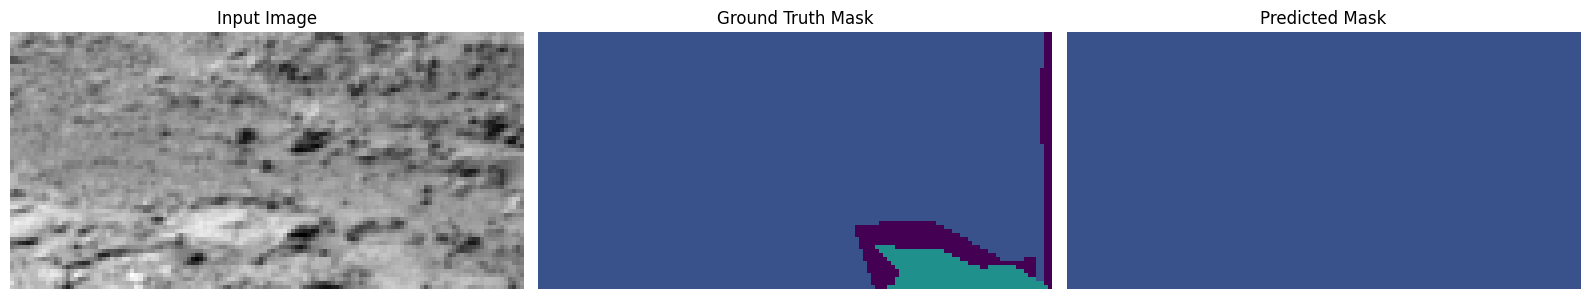

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5972 - loss: 0.7443 - mean_iou: 0.5264 - val_accuracy: 0.6015 - val_loss: 0.7461 - val_mean_iou: 0.5202 - learning_rate: 1.0000e-04
Epoch 92/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6358 - loss: 0.6961 - mean_iou: 0.5689 - val_accuracy: 0.5795 - val_loss: 0.7455 - val_mean_iou: 0.4989 - learning_rate: 1.0000e-04
Epoch 93/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6449 - loss: 0.6788 - mean_iou: 0.5832 - val_accuracy: 0.6003 - val_loss: 0.7086 - val_mean_iou: 0.5333 - learning_rate: 1.0000e-04
Epoch 94/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6334 - loss: 0.6927 - mean_iou: 0.5655 - val_accuracy: 0.5557 - val_loss: 0.8081 - val_mean_iou: 0.4793 - learning_rate: 1.0000e-04
Epoch 95/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5976 - loss: 0.7845 - mean_iou: 0.5208 - val_accuracy: 0.5178 - val_loss: 0.7977 - val_mean_iou: 0.4548 - learning_rate: 1.0000e-04

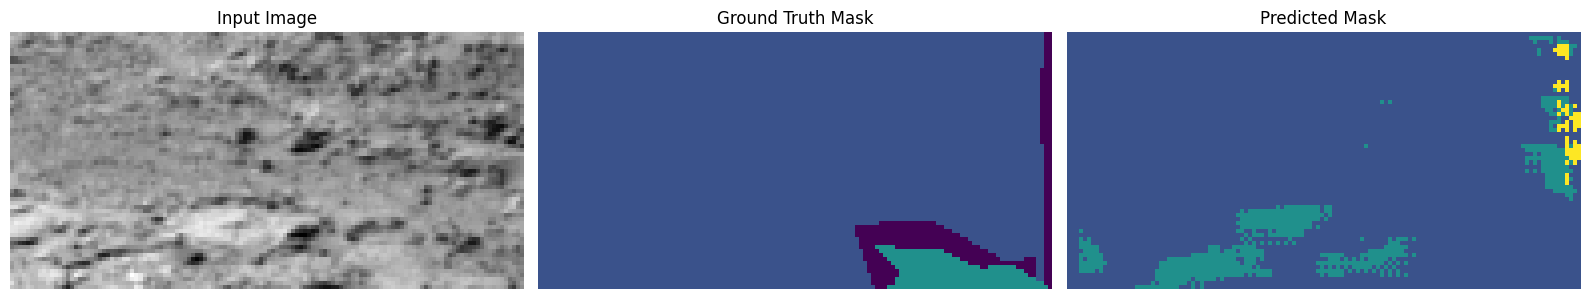

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6049 - loss: 0.7403 - mean_iou: 0.5320 - val_accuracy: 0.5981 - val_loss: 0.7130 - val_mean_iou: 0.5290 - learning_rate: 1.0000e-04
Epoch 97/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6278 - loss: 0.7047 - mean_iou: 0.5593 - val_accuracy: 0.6112 - val_loss: 0.7415 - val_mean_iou: 0.5363 - learning_rate: 1.0000e-04
Epoch 98/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6392 - loss: 0.6858 - mean_iou: 0.5731 - val_accuracy: 0.6003 - val_loss: 0.7257 - val_mean_iou: 0.5274 - learning_rate: 1.0000e-04
Epoch 99/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6449 - loss: 0.6768 - mean_iou: 0.5823 - val_accuracy: 0.5926 - val_loss: 0.7190 - val_mean_iou: 0.5199 - learning_rate: 1.0000e-04
Epoch 100/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6328 - loss: 0.6953 - mean_iou: 0.5651 - val_accuracy: 0.5979 - val_loss: 0.7203 - val_mean_iou: 0.5272 - learning_rate: 1.0000e-0

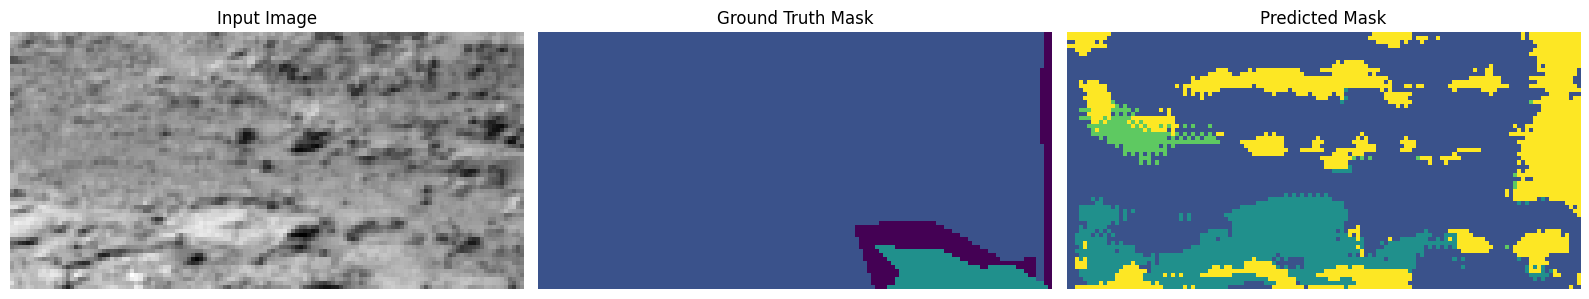

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6360 - loss: 0.6950 - mean_iou: 0.5694 - val_accuracy: 0.5303 - val_loss: 0.8178 - val_mean_iou: 0.4556 - learning_rate: 1.0000e-04
Epoch 102/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6237 - loss: 0.7099 - mean_iou: 0.5558 - val_accuracy: 0.6132 - val_loss: 0.7148 - val_mean_iou: 0.5385 - learning_rate: 1.0000e-04
Epoch 103/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6506 - loss: 0.6620 - mean_iou: 0.5918 - val_accuracy: 0.6251 - val_loss: 0.6973 - val_mean_iou: 0.5529 - learning_rate: 1.0000e-04
Epoch 104/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6527 - loss: 0.6632 - mean_iou: 0.5937 - val_accuracy: 0.5228 - val_loss: 0.7995 - val_mean_iou: 0.4607 - learning_rate: 1.0000e-04
Epoch 105/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6215 - loss: 0.7097 - mean_iou: 0.5550 - val_accuracy: 0.6167 - val_loss: 0.7055 - val_mean_iou: 0.5481 - learning_rate: 1.0000

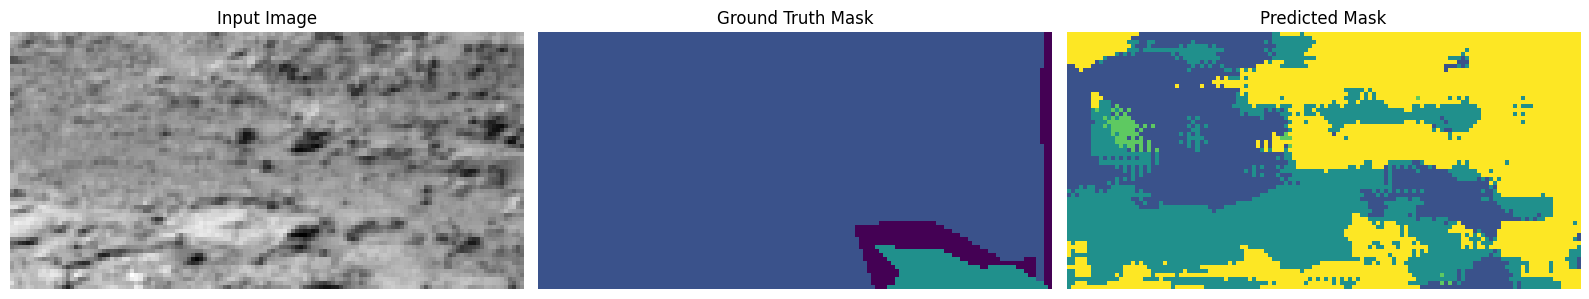

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6424 - loss: 0.6683 - mean_iou: 0.5780 - val_accuracy: 0.5233 - val_loss: 0.8158 - val_mean_iou: 0.4535 - learning_rate: 1.0000e-04
Epoch 107/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6261 - loss: 0.6934 - mean_iou: 0.5612 - val_accuracy: 0.6205 - val_loss: 0.6949 - val_mean_iou: 0.5435 - learning_rate: 1.0000e-04
Epoch 108/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6530 - loss: 0.6548 - mean_iou: 0.5931 - val_accuracy: 0.6068 - val_loss: 0.7366 - val_mean_iou: 0.5314 - learning_rate: 1.0000e-04
Epoch 109/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6489 - loss: 0.6722 - mean_iou: 0.5874 - val_accuracy: 0.6187 - val_loss: 0.7131 - val_mean_iou: 0.5413 - learning_rate: 1.0000e-04
Epoch 110/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.6471 - loss: 0.6670 - mean_iou: 0.5841 - val_accuracy: 0.6219 - val_loss: 0.6993 - val_mean_iou: 0.5544 - learning_rate: 1.0000

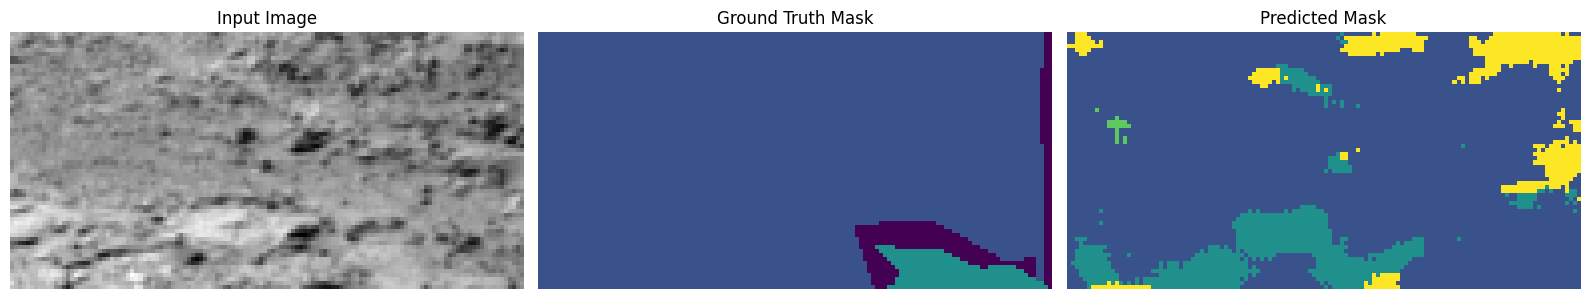

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.6487 - loss: 0.6642 - mean_iou: 0.5881 - val_accuracy: 0.5896 - val_loss: 0.7488 - val_mean_iou: 0.5139 - learning_rate: 1.0000e-04
Epoch 112/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6445 - loss: 0.6805 - mean_iou: 0.5813 - val_accuracy: 0.6139 - val_loss: 0.6970 - val_mean_iou: 0.5431 - learning_rate: 1.0000e-04
Epoch 113/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6508 - loss: 0.6600 - mean_iou: 0.5905 - val_accuracy: 0.5910 - val_loss: 0.7124 - val_mean_iou: 0.5290 - learning_rate: 1.0000e-04
Epoch 114/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6441 - loss: 0.6612 - mean_iou: 0.5825 - val_accuracy: 0.5832 - val_loss: 0.7466 - val_mean_iou: 0.5160 - learning_rate: 1.0000e-04
Epoch 115/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6423 - loss: 0.6799 - mean_iou: 0.5814 - val_accuracy: 0.5390 - val_loss: 0.7708 - val_mean_iou: 0.4697 - learning_rate: 1.0000

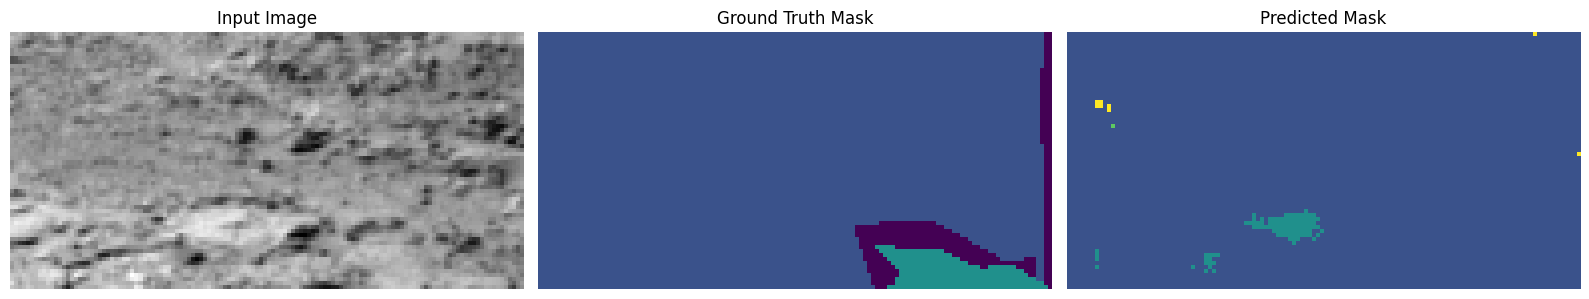

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6062 - loss: 0.7269 - mean_iou: 0.5310 - val_accuracy: 0.6246 - val_loss: 0.6842 - val_mean_iou: 0.5540 - learning_rate: 1.0000e-04
Epoch 117/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6633 - loss: 0.6353 - mean_iou: 0.6113 - val_accuracy: 0.6403 - val_loss: 0.6739 - val_mean_iou: 0.5783 - learning_rate: 1.0000e-04
Epoch 118/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6590 - loss: 0.6448 - mean_iou: 0.6041 - val_accuracy: 0.5636 - val_loss: 0.7786 - val_mean_iou: 0.4869 - learning_rate: 1.0000e-04
Epoch 119/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6177 - loss: 0.7224 - mean_iou: 0.5477 - val_accuracy: 0.5922 - val_loss: 0.7112 - val_mean_iou: 0.5293 - learning_rate: 1.0000e-04
Epoch 120/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6318 - loss: 0.6844 - mean_iou: 0.5656 - val_accuracy: 0.6111 - val_loss: 0.7148 - val_mean_iou: 0.5520 - learning_rate: 1.0000

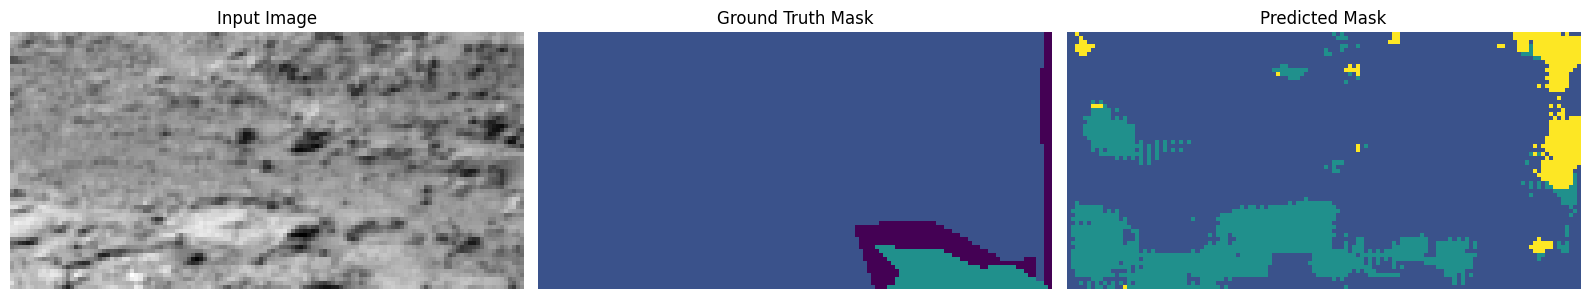

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6554 - loss: 0.6525 - mean_iou: 0.6008 - val_accuracy: 0.6228 - val_loss: 0.6736 - val_mean_iou: 0.5609 - learning_rate: 1.0000e-04
Epoch 122/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6552 - loss: 0.6526 - mean_iou: 0.5989 - val_accuracy: 0.6309 - val_loss: 0.6933 - val_mean_iou: 0.5628 - learning_rate: 1.0000e-04
Epoch 123/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6557 - loss: 0.6460 - mean_iou: 0.5977 - val_accuracy: 0.6285 - val_loss: 0.6893 - val_mean_iou: 0.5623 - learning_rate: 1.0000e-04
Epoch 124/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6598 - loss: 0.6356 - mean_iou: 0.6053 - val_accuracy: 0.6365 - val_loss: 0.6809 - val_mean_iou: 0.5702 - learning_rate: 1.0000e-04
Epoch 125/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6629 - loss: 0.6409 - mean_iou: 0.6100 - val_accuracy: 0.6344 - val_loss: 0.6885 - val_mean_iou: 0.5705 - learning_rate: 1.0000

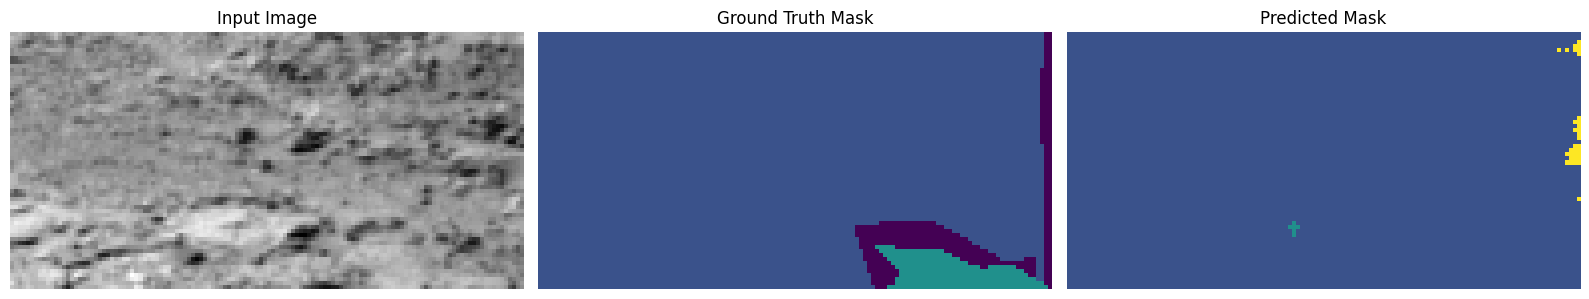

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6620 - loss: 0.6333 - mean_iou: 0.6095 - val_accuracy: 0.6258 - val_loss: 0.6830 - val_mean_iou: 0.5523 - learning_rate: 1.0000e-04
Epoch 127/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6547 - loss: 0.6538 - mean_iou: 0.5967 - val_accuracy: 0.5844 - val_loss: 0.7242 - val_mean_iou: 0.5233 - learning_rate: 1.0000e-04
Epoch 128/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6263 - loss: 0.6852 - mean_iou: 0.5612 - val_accuracy: 0.6419 - val_loss: 0.6823 - val_mean_iou: 0.5752 - learning_rate: 1.0000e-04
Epoch 129/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6684 - loss: 0.6279 - mean_iou: 0.6181 - val_accuracy: 0.6145 - val_loss: 0.6955 - val_mean_iou: 0.5493 - learning_rate: 1.0000e-04
Epoch 130/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6603 - loss: 0.6423 - mean_iou: 0.6055 - val_accuracy: 0.6345 - val_loss: 0.6731 - val_mean_iou: 0.5692 - learning_rate: 1.0000

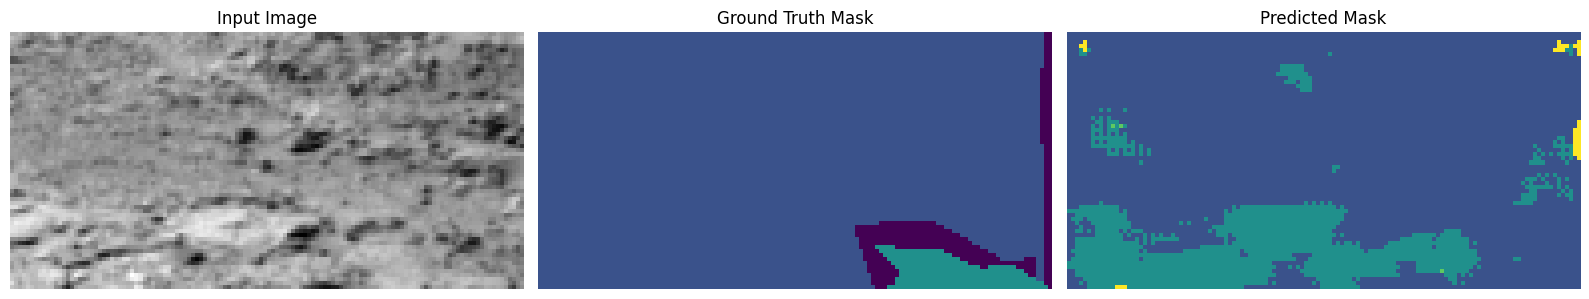

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6743 - loss: 0.6105 - mean_iou: 0.6289 - val_accuracy: 0.6379 - val_loss: 0.6956 - val_mean_iou: 0.5688 - learning_rate: 1.0000e-04
Epoch 132/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6672 - loss: 0.6270 - mean_iou: 0.6167 - val_accuracy: 0.6437 - val_loss: 0.6800 - val_mean_iou: 0.5813 - learning_rate: 1.0000e-04
Epoch 133/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6652 - loss: 0.6301 - mean_iou: 0.6129 - val_accuracy: 0.6420 - val_loss: 0.7199 - val_mean_iou: 0.5760 - learning_rate: 1.0000e-04
Epoch 134/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6712 - loss: 0.6212 - mean_iou: 0.6245 - val_accuracy: 0.4800 - val_loss: 0.8774 - val_mean_iou: 0.4136 - learning_rate: 1.0000e-04
Epoch 135/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6206 - loss: 0.7081 - mean_iou: 0.5598 - val_accuracy: 0.6376 - val_loss: 0.7000 - val_mean_iou: 0.5704 - learning_rate: 1.0000

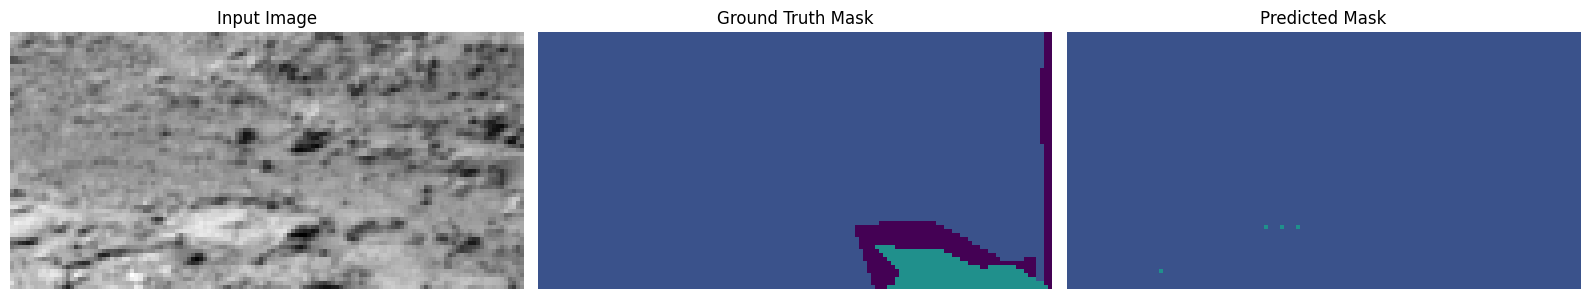

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6549 - loss: 0.6598 - mean_iou: 0.5968 - val_accuracy: 0.6243 - val_loss: 0.7017 - val_mean_iou: 0.5559 - learning_rate: 1.0000e-04
Epoch 137/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6534 - loss: 0.6519 - mean_iou: 0.5954 - val_accuracy: 0.6350 - val_loss: 0.6855 - val_mean_iou: 0.5712 - learning_rate: 1.0000e-04
Epoch 138/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6690 - loss: 0.6235 - mean_iou: 0.6199 - val_accuracy: 0.5946 - val_loss: 0.7203 - val_mean_iou: 0.5266 - learning_rate: 1.0000e-04
Epoch 139/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6469 - loss: 0.6615 - mean_iou: 0.5851 - val_accuracy: 0.6418 - val_loss: 0.6925 - val_mean_iou: 0.5747 - learning_rate: 1.0000e-04
Epoch 140/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6653 - loss: 0.6279 - mean_iou: 0.6144 - val_accuracy: 0.6428 - val_loss: 0.6828 - val_mean_iou: 0.5797 - learning_rate: 1.0000

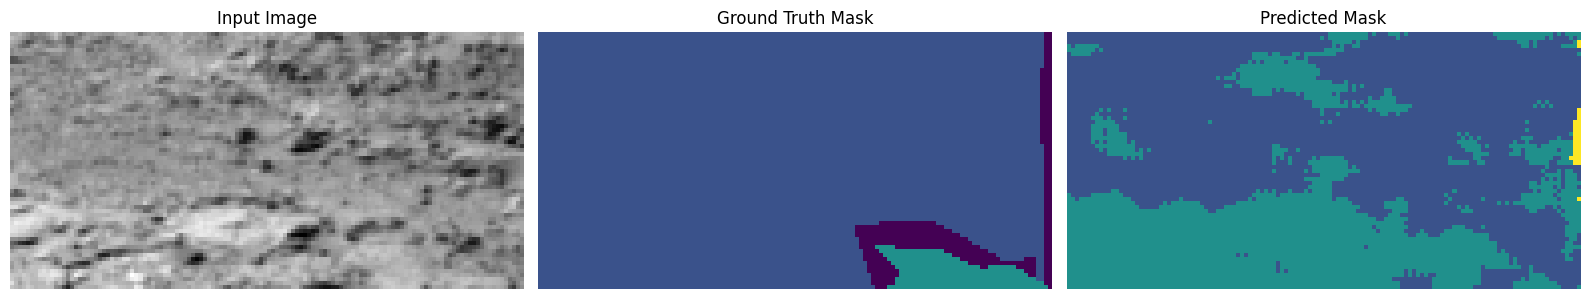

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6663 - loss: 0.6263 - mean_iou: 0.6162 - val_accuracy: 0.6471 - val_loss: 0.6797 - val_mean_iou: 0.5812 - learning_rate: 1.0000e-04
Epoch 142/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6789 - loss: 0.6042 - mean_iou: 0.6357 - val_accuracy: 0.6433 - val_loss: 0.7070 - val_mean_iou: 0.5766 - learning_rate: 1.0000e-04
Epoch 143/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6836 - loss: 0.6004 - mean_iou: 0.6452 - val_accuracy: 0.6373 - val_loss: 0.6729 - val_mean_iou: 0.5730 - learning_rate: 1.0000e-04
Epoch 144/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6709 - loss: 0.6187 - mean_iou: 0.6233 - val_accuracy: 0.6454 - val_loss: 0.6646 - val_mean_iou: 0.5842 - learning_rate: 1.0000e-04
Epoch 145/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6731 - loss: 0.6132 - mean_iou: 0.6258 - val_accuracy: 0.5650 - val_loss: 0.7744 - val_mean_iou: 0.5041 - learning_rate: 1.0000

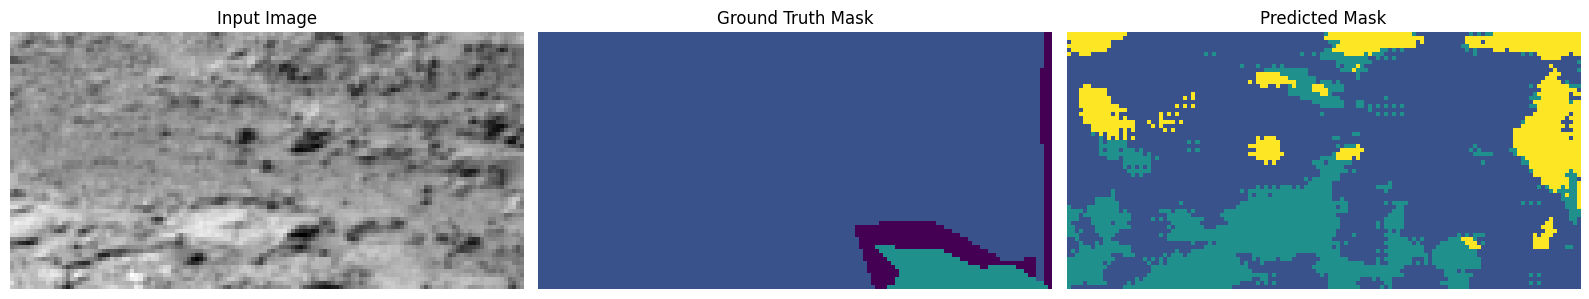

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6408 - loss: 0.6696 - mean_iou: 0.5844 - val_accuracy: 0.6080 - val_loss: 0.6892 - val_mean_iou: 0.5487 - learning_rate: 1.0000e-04
Epoch 147/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6627 - loss: 0.6275 - mean_iou: 0.6104 - val_accuracy: 0.6347 - val_loss: 0.6816 - val_mean_iou: 0.5667 - learning_rate: 1.0000e-04
Epoch 148/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6721 - loss: 0.6098 - mean_iou: 0.6257 - val_accuracy: 0.6463 - val_loss: 0.6844 - val_mean_iou: 0.5813 - learning_rate: 1.0000e-04
Epoch 149/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6845 - loss: 0.5878 - mean_iou: 0.6457 - val_accuracy: 0.6496 - val_loss: 0.6983 - val_mean_iou: 0.5845 - learning_rate: 1.0000e-04
Epoch 150/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6836 - loss: 0.5935 - mean_iou: 0.6440 - val_accuracy: 0.6427 - val_loss: 0.7115 - val_mean_iou: 0.5736 - learning_rate: 1.0000

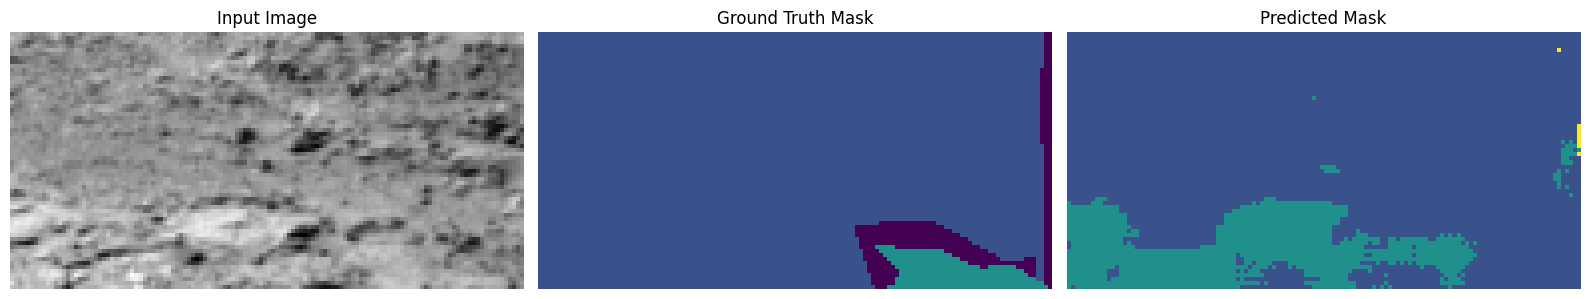

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6713 - loss: 0.6191 - mean_iou: 0.6225 - val_accuracy: 0.6599 - val_loss: 0.7520 - val_mean_iou: 0.5986 - learning_rate: 1.0000e-04
Epoch 152/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6787 - loss: 0.6034 - mean_iou: 0.6343 - val_accuracy: 0.6425 - val_loss: 0.6781 - val_mean_iou: 0.5764 - learning_rate: 1.0000e-04
Epoch 153/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6851 - loss: 0.5871 - mean_iou: 0.6470 - val_accuracy: 0.4583 - val_loss: 0.9548 - val_mean_iou: 0.3772 - learning_rate: 1.0000e-04
Epoch 154/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.5802 - loss: 0.8004 - mean_iou: 0.5011 - val_accuracy: 0.6202 - val_loss: 0.6906 - val_mean_iou: 0.5573 - learning_rate: 1.0000e-04
Epoch 155/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6638 - loss: 0.6368 - mean_iou: 0.6111 - val_accuracy: 0.6445 - val_loss: 0.7159 - val_mean_iou: 0.5744 - learning_rate: 1.0000

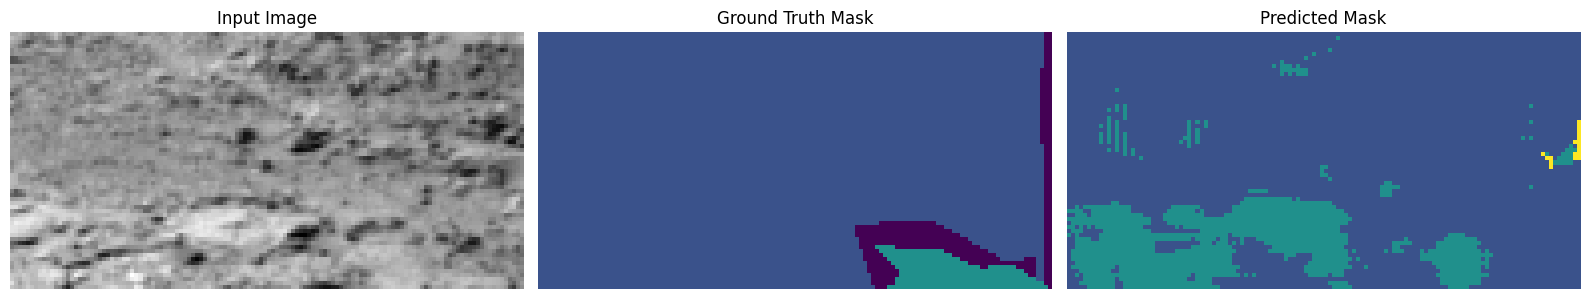

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6715 - loss: 0.6203 - mean_iou: 0.6227 - val_accuracy: 0.6469 - val_loss: 0.6722 - val_mean_iou: 0.5822 - learning_rate: 1.0000e-04
Epoch 157/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6748 - loss: 0.6111 - mean_iou: 0.6283 - val_accuracy: 0.6363 - val_loss: 0.7134 - val_mean_iou: 0.5661 - learning_rate: 1.0000e-04
Epoch 158/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6707 - loss: 0.6173 - mean_iou: 0.6222 - val_accuracy: 0.6358 - val_loss: 0.6843 - val_mean_iou: 0.5743 - learning_rate: 1.0000e-04
Epoch 159/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6718 - loss: 0.6220 - mean_iou: 0.6245 - val_accuracy: 0.6063 - val_loss: 0.7195 - val_mean_iou: 0.5425 - learning_rate: 1.0000e-04
Epoch 160/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6718 - loss: 0.6007 - mean_iou: 0.6286 - val_accuracy: 0.6644 - val_loss: 0.6798 - val_mean_iou: 0.6056 - learning_rate: 1.0000

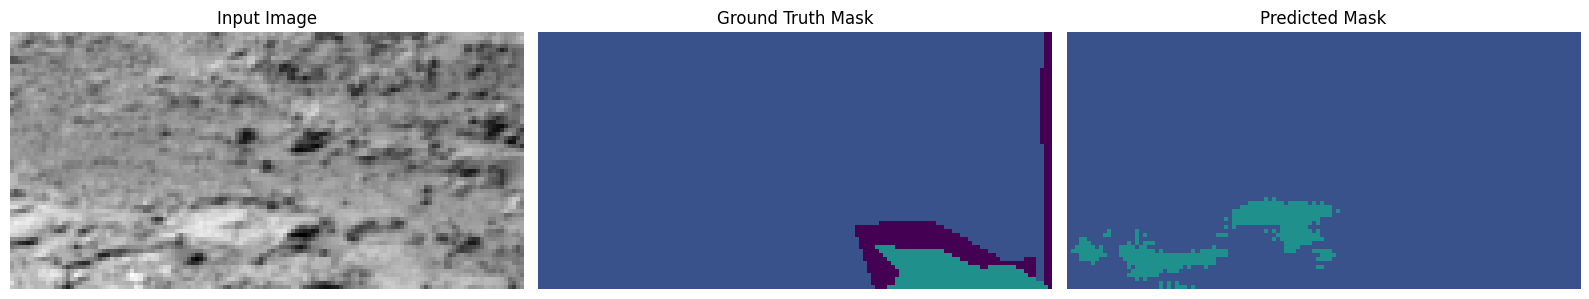

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6938 - loss: 0.5760 - mean_iou: 0.6619 - val_accuracy: 0.6625 - val_loss: 0.6890 - val_mean_iou: 0.6028 - learning_rate: 1.0000e-05
Epoch 162/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6939 - loss: 0.5682 - mean_iou: 0.6634 - val_accuracy: 0.6643 - val_loss: 0.6892 - val_mean_iou: 0.6055 - learning_rate: 1.0000e-05
Epoch 163/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6939 - loss: 0.5685 - mean_iou: 0.6626 - val_accuracy: 0.6652 - val_loss: 0.6792 - val_mean_iou: 0.6081 - learning_rate: 1.0000e-05
Epoch 164/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6909 - loss: 0.5687 - mean_iou: 0.6567 - val_accuracy: 0.6629 - val_loss: 0.7202 - val_mean_iou: 0.6021 - learning_rate: 1.0000e-05
Epoch 165/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6956 - loss: 0.5654 - mean_iou: 0.6660 - val_accuracy: 0.6592 - val_loss: 0.7106 - val_mean_iou: 0.5971 - learning_rate: 1.0000

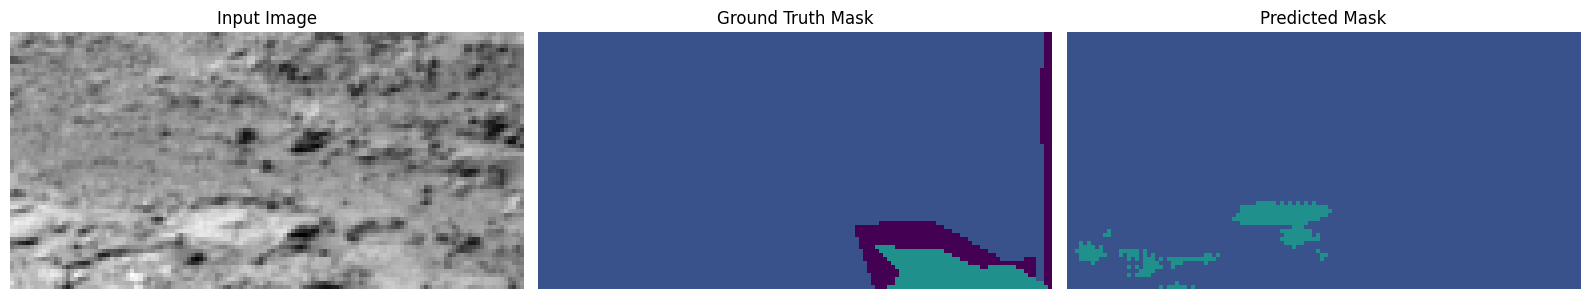

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6964 - loss: 0.5619 - mean_iou: 0.6676 - val_accuracy: 0.6627 - val_loss: 0.7116 - val_mean_iou: 0.6028 - learning_rate: 1.0000e-05
Epoch 167/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7008 - loss: 0.5542 - mean_iou: 0.6769 - val_accuracy: 0.6631 - val_loss: 0.7151 - val_mean_iou: 0.6033 - learning_rate: 1.0000e-05
Epoch 168/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7015 - loss: 0.5558 - mean_iou: 0.6789 - val_accuracy: 0.6636 - val_loss: 0.7083 - val_mean_iou: 0.6052 - learning_rate: 1.0000e-05
Epoch 169/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7005 - loss: 0.5560 - mean_iou: 0.6759 - val_accuracy: 0.6660 - val_loss: 0.7331 - val_mean_iou: 0.6085 - learning_rate: 1.0000e-05
Epoch 170/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7003 - loss: 0.5548 - mean_iou: 0.6756 - val_accuracy: 0.6664 - val_loss: 0.7400 - val_mean_iou: 0.6076 - learning_rate: 1.0000

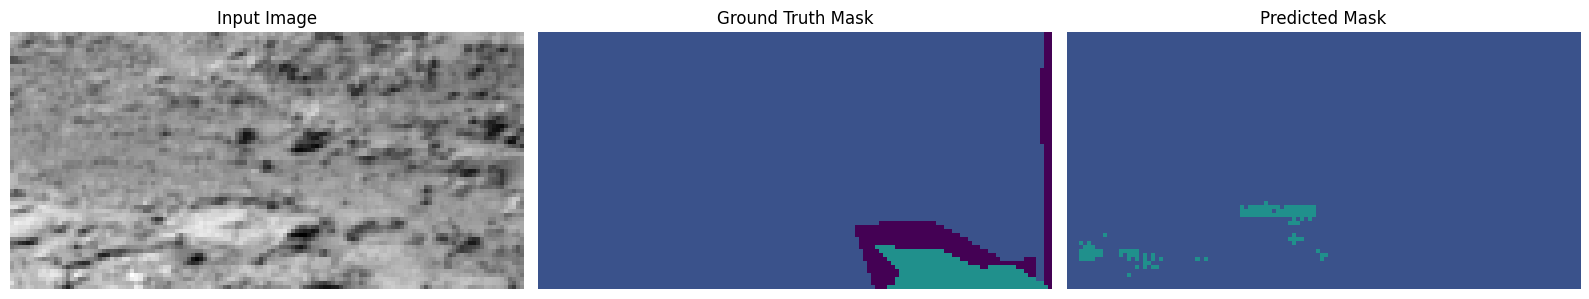

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7022 - loss: 0.5513 - mean_iou: 0.6804 - val_accuracy: 0.6648 - val_loss: 0.7132 - val_mean_iou: 0.6074 - learning_rate: 1.0000e-05
Epoch 172/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7029 - loss: 0.5512 - mean_iou: 0.6806 - val_accuracy: 0.6651 - val_loss: 0.7437 - val_mean_iou: 0.6055 - learning_rate: 1.0000e-05
Epoch 173/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7063 - loss: 0.5457 - mean_iou: 0.6894 - val_accuracy: 0.6680 - val_loss: 0.7268 - val_mean_iou: 0.6099 - learning_rate: 1.0000e-05
Epoch 174/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7062 - loss: 0.5481 - mean_iou: 0.6893 - val_accuracy: 0.6654 - val_loss: 0.7431 - val_mean_iou: 0.6056 - learning_rate: 1.0000e-05
Epoch 175/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7078 - loss: 0.5451 - mean_iou: 0.6923 - val_accuracy: 0.6694 - val_loss: 0.7278 - val_mean_iou: 0.6124 - learning_rate: 1.0000

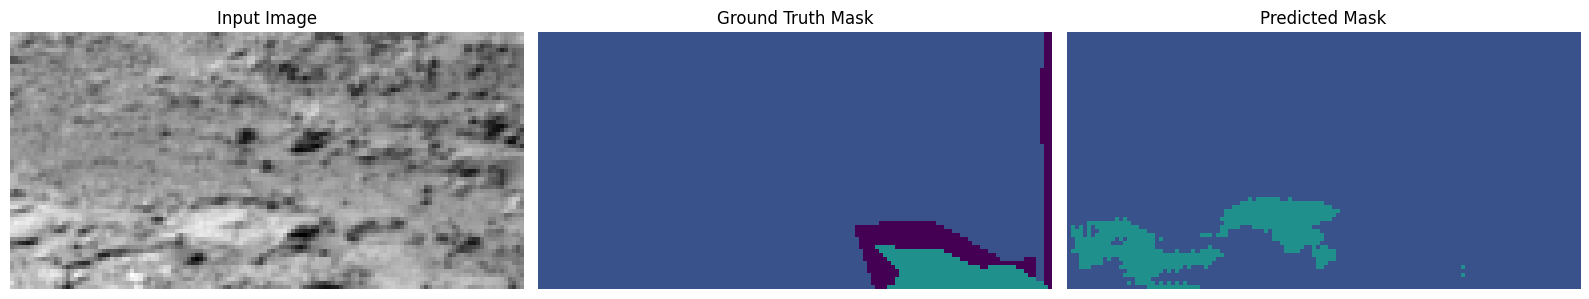

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7060 - loss: 0.5449 - mean_iou: 0.6895 - val_accuracy: 0.6692 - val_loss: 0.7250 - val_mean_iou: 0.6122 - learning_rate: 1.0000e-06
Epoch 177/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7041 - loss: 0.5469 - mean_iou: 0.6854 - val_accuracy: 0.6701 - val_loss: 0.7228 - val_mean_iou: 0.6137 - learning_rate: 1.0000e-06
Epoch 178/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7090 - loss: 0.5378 - mean_iou: 0.6951 - val_accuracy: 0.6691 - val_loss: 0.7256 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-06
Epoch 179/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7093 - loss: 0.5429 - mean_iou: 0.6959 - val_accuracy: 0.6689 - val_loss: 0.7202 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-06
Epoch 180/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7069 - loss: 0.5429 - mean_iou: 0.6902 - val_accuracy: 0.6686 - val_loss: 0.7234 - val_mean_iou: 0.6114 - learning_rate: 1.0000

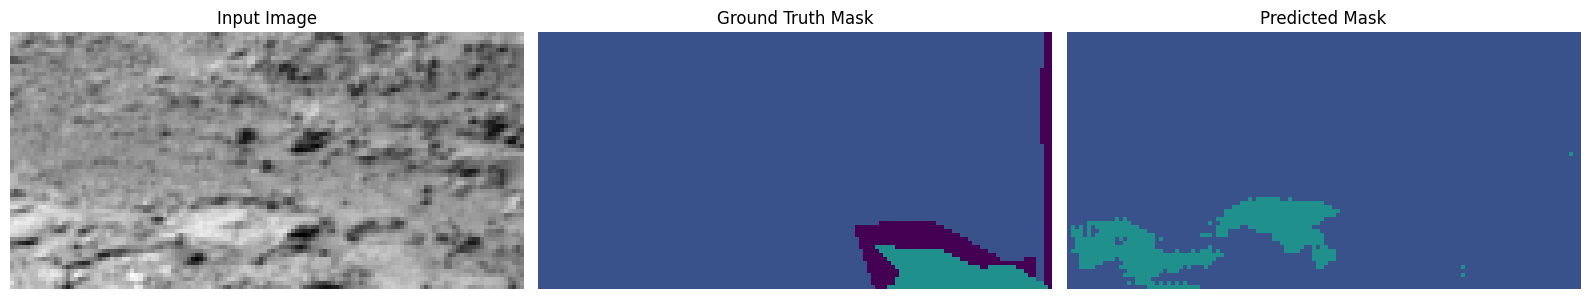

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7043 - loss: 0.5496 - mean_iou: 0.6844 - val_accuracy: 0.6680 - val_loss: 0.7126 - val_mean_iou: 0.6110 - learning_rate: 1.0000e-06
Epoch 182/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7076 - loss: 0.5390 - mean_iou: 0.6898 - val_accuracy: 0.6678 - val_loss: 0.7223 - val_mean_iou: 0.6102 - learning_rate: 1.0000e-06
Epoch 183/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7065 - loss: 0.5420 - mean_iou: 0.6882 - val_accuracy: 0.6690 - val_loss: 0.7263 - val_mean_iou: 0.6121 - learning_rate: 1.0000e-06
Epoch 184/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7062 - loss: 0.5416 - mean_iou: 0.6904 - val_accuracy: 0.6690 - val_loss: 0.7249 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-06
Epoch 185/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7063 - loss: 0.5440 - mean_iou: 0.6895 - val_accuracy: 0.6697 - val_loss: 0.7252 - val_mean_iou: 0.6131 - learning_rate: 1.0000

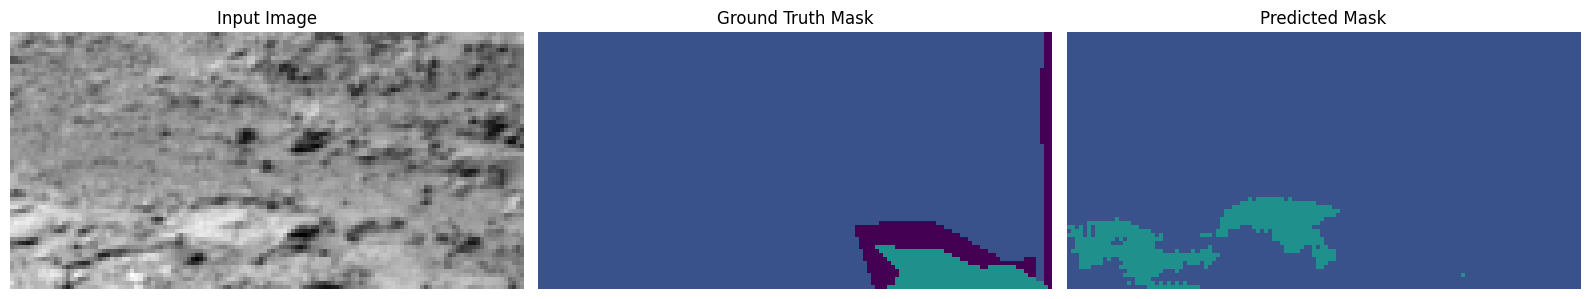

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7095 - loss: 0.5355 - mean_iou: 0.6958 - val_accuracy: 0.6695 - val_loss: 0.7268 - val_mean_iou: 0.6127 - learning_rate: 1.0000e-06
Epoch 187/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7068 - loss: 0.5400 - mean_iou: 0.6915 - val_accuracy: 0.6695 - val_loss: 0.7269 - val_mean_iou: 0.6126 - learning_rate: 1.0000e-06
Epoch 188/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7072 - loss: 0.5370 - mean_iou: 0.6914 - val_accuracy: 0.6700 - val_loss: 0.7283 - val_mean_iou: 0.6133 - learning_rate: 1.0000e-06
Epoch 189/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7061 - loss: 0.5439 - mean_iou: 0.6910 - val_accuracy: 0.6688 - val_loss: 0.7266 - val_mean_iou: 0.6116 - learning_rate: 1.0000e-06
Epoch 190/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7059 - loss: 0.5426 - mean_iou: 0.6888 - val_accuracy: 0.6688 - val_loss: 0.7264 - val_mean_iou: 0.6116 - learning_rate: 1.0000

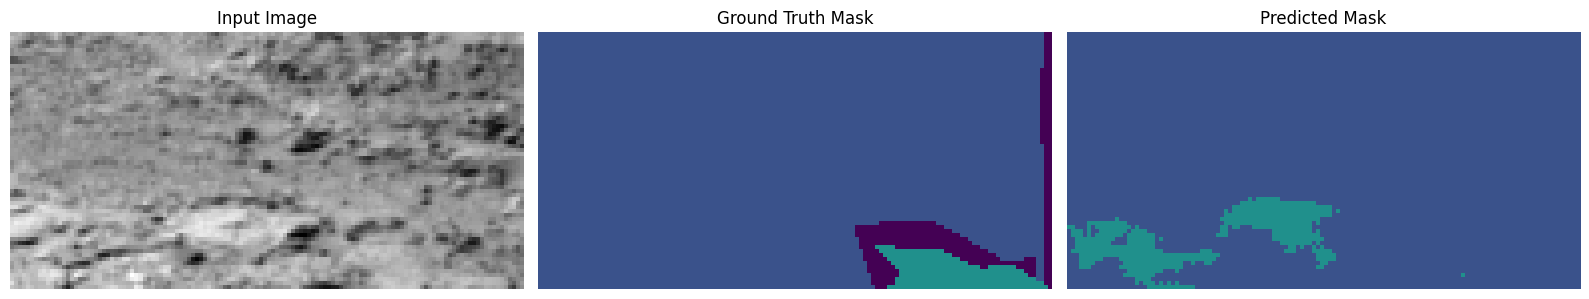

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7082 - loss: 0.5357 - mean_iou: 0.6938 - val_accuracy: 0.6687 - val_loss: 0.7264 - val_mean_iou: 0.6115 - learning_rate: 1.0000e-07
Epoch 192/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7062 - loss: 0.5417 - mean_iou: 0.6891 - val_accuracy: 0.6688 - val_loss: 0.7268 - val_mean_iou: 0.6116 - learning_rate: 1.0000e-07
Epoch 193/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7088 - loss: 0.5375 - mean_iou: 0.6951 - val_accuracy: 0.6687 - val_loss: 0.7268 - val_mean_iou: 0.6115 - learning_rate: 1.0000e-07
Epoch 194/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7109 - loss: 0.5353 - mean_iou: 0.6983 - val_accuracy: 0.6688 - val_loss: 0.7267 - val_mean_iou: 0.6116 - learning_rate: 1.0000e-07
Epoch 195/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7074 - loss: 0.5378 - mean_iou: 0.6924 - val_accuracy: 0.6689 - val_loss: 0.7268 - val_mean_iou: 0.6117 - learning_rate: 1.0000

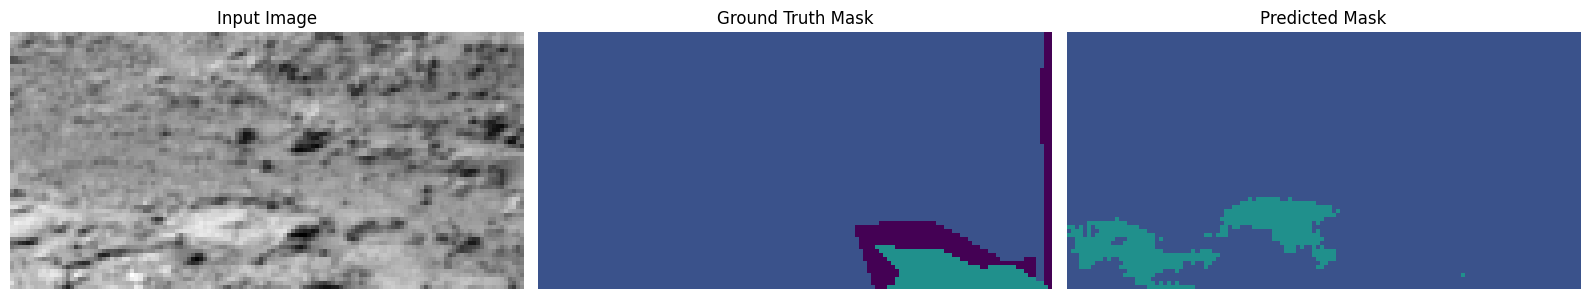

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7064 - loss: 0.5405 - mean_iou: 0.6901 - val_accuracy: 0.6689 - val_loss: 0.7267 - val_mean_iou: 0.6117 - learning_rate: 1.0000e-07
Epoch 197/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7086 - loss: 0.5376 - mean_iou: 0.6946 - val_accuracy: 0.6689 - val_loss: 0.7264 - val_mean_iou: 0.6118 - learning_rate: 1.0000e-07
Epoch 198/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7072 - loss: 0.5385 - mean_iou: 0.6922 - val_accuracy: 0.6689 - val_loss: 0.7263 - val_mean_iou: 0.6117 - learning_rate: 1.0000e-07
Epoch 199/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7073 - loss: 0.5404 - mean_iou: 0.6920 - val_accuracy: 0.6690 - val_loss: 0.7263 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-07
Epoch 200/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7086 - loss: 0.5370 - mean_iou: 0.6940 - val_accuracy: 0.6690 - val_loss: 0.7269 - val_mean_iou: 0.6119 - learning_rate: 1.0000

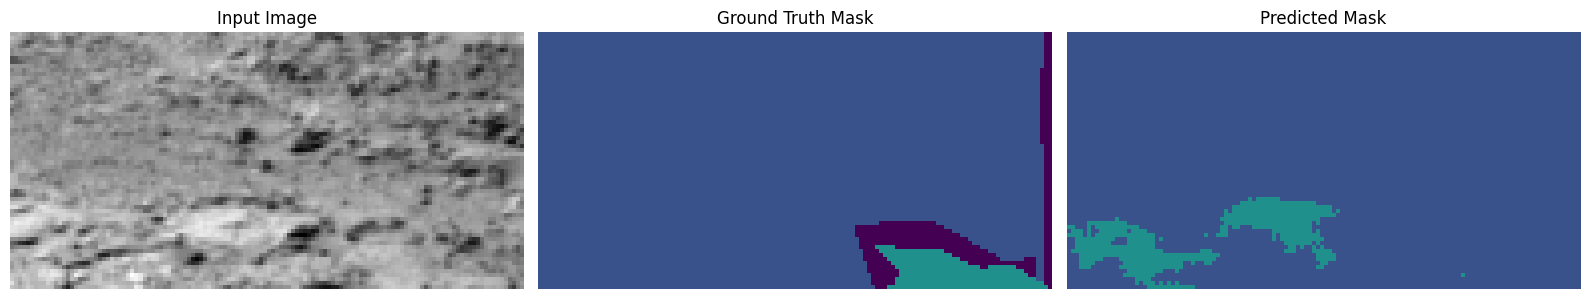

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7079 - loss: 0.5399 - mean_iou: 0.6925 - val_accuracy: 0.6689 - val_loss: 0.7269 - val_mean_iou: 0.6117 - learning_rate: 1.0000e-07
Epoch 202/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7086 - loss: 0.5368 - mean_iou: 0.6946 - val_accuracy: 0.6687 - val_loss: 0.7276 - val_mean_iou: 0.6114 - learning_rate: 1.0000e-07
Epoch 203/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7087 - loss: 0.5363 - mean_iou: 0.6951 - val_accuracy: 0.6690 - val_loss: 0.7273 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-07
Epoch 204/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7066 - loss: 0.5398 - mean_iou: 0.6909 - val_accuracy: 0.6691 - val_loss: 0.7272 - val_mean_iou: 0.6121 - learning_rate: 1.0000e-07
Epoch 205/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7082 - loss: 0.5384 - mean_iou: 0.6939 - val_accuracy: 0.6691 - val_loss: 0.7271 - val_mean_iou: 0.6121 - learning_rate: 1.0000

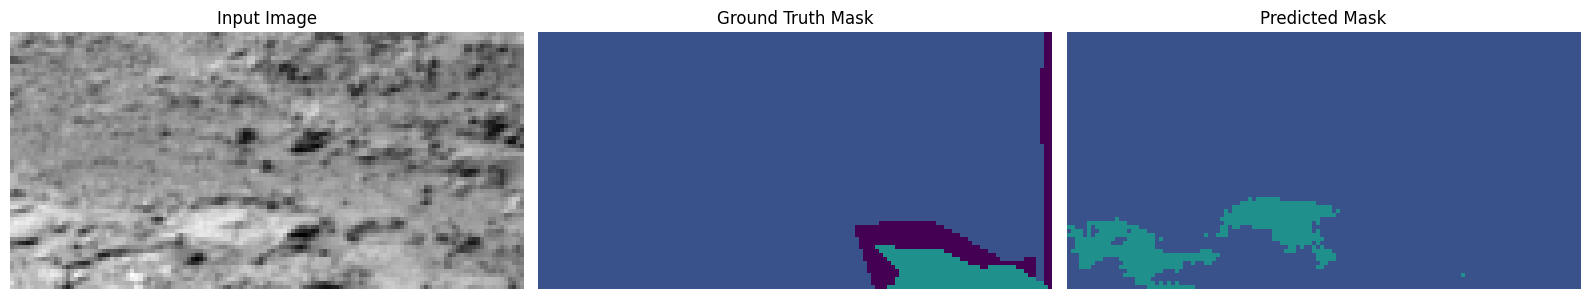

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7073 - loss: 0.5407 - mean_iou: 0.6920 - val_accuracy: 0.6691 - val_loss: 0.7271 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 207/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7089 - loss: 0.5369 - mean_iou: 0.6947 - val_accuracy: 0.6691 - val_loss: 0.7272 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 208/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7058 - loss: 0.5405 - mean_iou: 0.6900 - val_accuracy: 0.6691 - val_loss: 0.7272 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 209/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7068 - loss: 0.5415 - mean_iou: 0.6912 - val_accuracy: 0.6691 - val_loss: 0.7273 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 210/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7071 - loss: 0.5373 - mean_iou: 0.6915 - val_accuracy: 0.6691 - val_loss: 0.7273 - val_mean_iou: 0.6120 - learning_rate: 1.0000

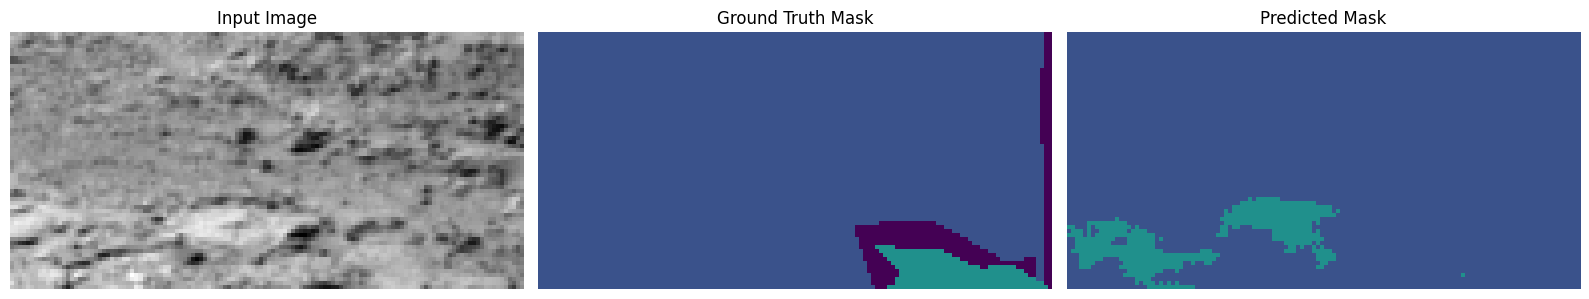

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.7096 - loss: 0.5355 - mean_iou: 0.6967 - val_accuracy: 0.6691 - val_loss: 0.7273 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 212/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7107 - loss: 0.5345 - mean_iou: 0.6979 - val_accuracy: 0.6690 - val_loss: 0.7273 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 213/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7098 - loss: 0.5357 - mean_iou: 0.6971 - val_accuracy: 0.6691 - val_loss: 0.7274 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-08
Epoch 214/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7094 - loss: 0.5390 - mean_iou: 0.6957 - val_accuracy: 0.6690 - val_loss: 0.7272 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 215/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7073 - loss: 0.5396 - mean_iou: 0.6925 - val_accuracy: 0.6690 - val_loss: 0.7273 - val_mean_iou: 0.6119 - learning_rate: 1.0000

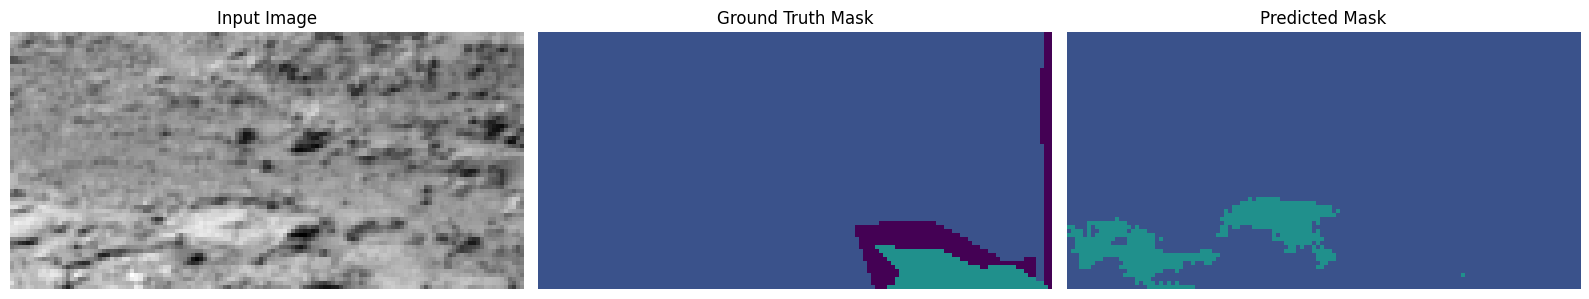

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7071 - loss: 0.5366 - mean_iou: 0.6915 - val_accuracy: 0.6690 - val_loss: 0.7273 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 217/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7075 - loss: 0.5393 - mean_iou: 0.6932 - val_accuracy: 0.6690 - val_loss: 0.7274 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 218/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7056 - loss: 0.5436 - mean_iou: 0.6883 - val_accuracy: 0.6690 - val_loss: 0.7274 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 219/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7089 - loss: 0.5382 - mean_iou: 0.6954 - val_accuracy: 0.6690 - val_loss: 0.7275 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 220/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7082 - loss: 0.5384 - mean_iou: 0.6944 - val_accuracy: 0.6690 - val_loss: 0.7275 - val_mean_iou: 0.6118 - learning_rate: 1.0000

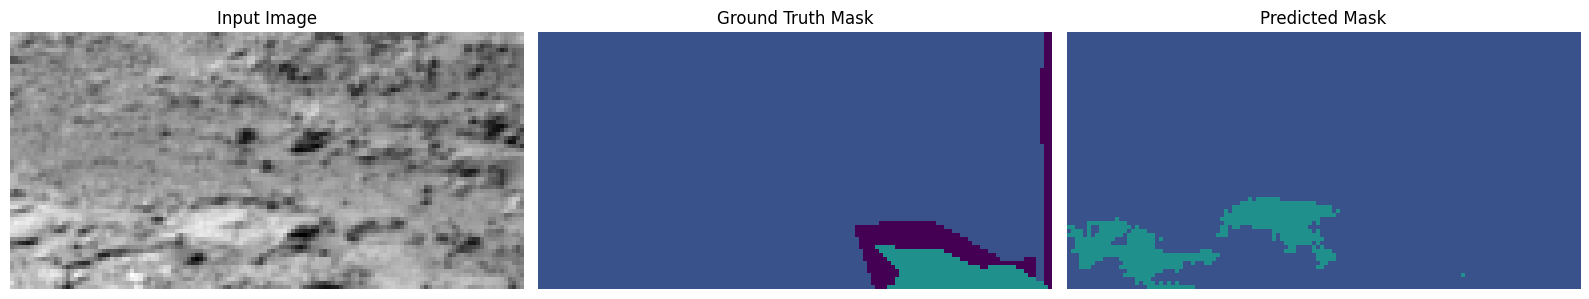

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7102 - loss: 0.5373 - mean_iou: 0.6969 - val_accuracy: 0.6690 - val_loss: 0.7275 - val_mean_iou: 0.6119 - learning_rate: 1.0000e-08
Epoch 222/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7099 - loss: 0.5357 - mean_iou: 0.6971 - val_accuracy: 0.6690 - val_loss: 0.7275 - val_mean_iou: 0.6118 - learning_rate: 1.0000e-08
Final validation Mean Intersection Over Union: 61.37%


In [32]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")

In [33]:
# Load the model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_113621.keras


## 📊 Prepare The Submission



In [34]:
# Load the model
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_113621.keras


In [35]:
# Predict
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step
Predictions shape: (10022, 64, 128)


In [36]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 723ms/step
Accuracy score over the test set: 0.6701


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score over the test set: 0.5348
Recall score over the test set: 0.6701
F1 score over the test set: 0.5931


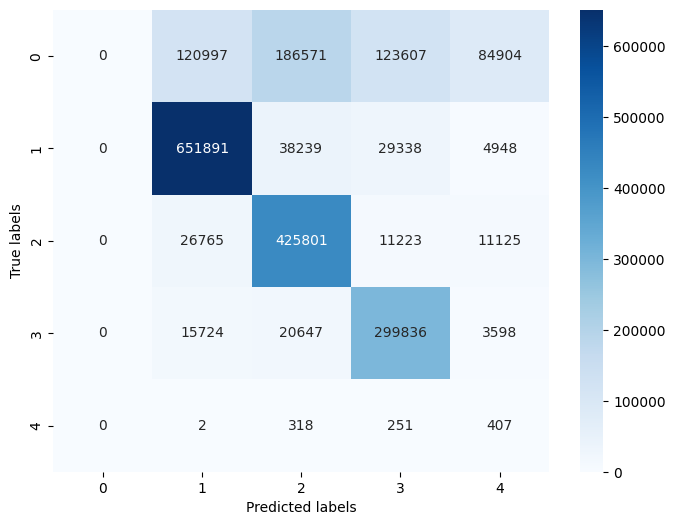

In [38]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

# Predict class probabilities and get predicted classes on the validation set
test_predictions = np.argmax(model.predict(X_val), axis=-1).flatten()

# Extract ground truth classes
test_gt = y_val.flatten()

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
    cmap="Blues",
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

The results are good for classes 1 to 3, while the model has issues recognizing class 4. Class 0 is never predicted, as the loss function only penalizes misclassifications of class 0 indirectly.

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```